In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-05 03:48:12,732] A new study created in memory with name: no-name-360571d3-448b-45ad-8ed1-d66e45e632a3
[I 2025-06-05 03:49:53,435] Trial 0 finished with value: 0.09245930016040801 and parameters: {'lr': 0.008261735510652042, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2957617250613288}. Best is trial 0 with value: 0.09245930016040801.


Cross Validation Accuracies:
[0.11632125824689865, 0.0932241827249527, 0.0742986872792244, 0.10485602915287018, 0.07359634339809418]
Mean Cross Validation Accuracy:
0.09245930016040801
Standard Deviation of Cross Validation Accuracy:
0.01678854357476351


[I 2025-06-05 03:53:09,350] Trial 1 finished with value: 0.10797536671161652 and parameters: {'lr': 0.0010418490537411889, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43256307871298094}. Best is trial 0 with value: 0.09245930016040801.


Cross Validation Accuracies:
[0.11500400304794312, 0.09119317680597305, 0.10264786332845688, 0.12707363069057465, 0.10395815968513489]
Mean Cross Validation Accuracy:
0.10797536671161652
Standard Deviation of Cross Validation Accuracy:
0.012168052912266384


[I 2025-06-05 03:56:08,270] Trial 2 finished with value: 0.09137531071901321 and parameters: {'lr': 0.024539946068789696, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3356080654177164}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.10344681888818741, 0.10123804211616516, 0.07799216359853745, 0.10661308467388153, 0.06758644431829453]
Mean Cross Validation Accuracy:
0.09137531071901321
Standard Deviation of Cross Validation Accuracy:
0.015621800963205304


[I 2025-06-05 03:58:47,380] Trial 3 finished with value: 0.13321704864501954 and parameters: {'lr': 0.010832416762296288, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1009775659607108}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.12680235505104065, 0.10466122627258301, 0.17672304809093475, 0.13404564559459686, 0.12385296821594238]
Mean Cross Validation Accuracy:
0.13321704864501954
Standard Deviation of Cross Validation Accuracy:
0.023823214931011433


[I 2025-06-05 04:00:58,645] Trial 4 finished with value: 0.20558429956436158 and parameters: {'lr': 0.002868763000733348, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.26995773198952105}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.19887487590312958, 0.233266219496727, 0.19403231143951416, 0.19946476817131042, 0.2022833228111267]
Mean Cross Validation Accuracy:
0.20558429956436158
Standard Deviation of Cross Validation Accuracy:
0.014093250857345446


[I 2025-06-05 04:03:31,020] Trial 5 finished with value: 0.10650747865438462 and parameters: {'lr': 0.018112418353704078, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24249810024797502}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.17719681560993195, 0.097923643887043, 0.08524204045534134, 0.10404541343450546, 0.06812947988510132]
Mean Cross Validation Accuracy:
0.10650747865438462
Standard Deviation of Cross Validation Accuracy:
0.03742142700380976


[I 2025-06-05 04:07:24,322] Trial 6 finished with value: 2.5280136823654176 and parameters: {'lr': 0.7914284258820099, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1465838702153108}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[3.14215087890625, 3.3978347778320312, 2.5373470783233643, 1.6306896209716797, 1.9320460557937622]
Mean Cross Validation Accuracy:
2.5280136823654176
Standard Deviation of Cross Validation Accuracy:
0.6773785100889288


[I 2025-06-05 04:10:44,539] Trial 7 finished with value: 0.09464318454265594 and parameters: {'lr': 0.36442270418071593, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4209529699807847}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.11412985622882843, 0.08956137299537659, 0.07231184840202332, 0.1281294971704483, 0.06908334791660309]
Mean Cross Validation Accuracy:
0.09464318454265594
Standard Deviation of Cross Validation Accuracy:
0.023146844871772144


[I 2025-06-05 04:14:34,342] Trial 8 finished with value: 0.20020902454853057 and parameters: {'lr': 0.3672646756524512, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3700519554559826}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.2000741809606552, 0.19930462539196014, 0.2142515629529953, 0.18355651199817657, 0.20385824143886566]
Mean Cross Validation Accuracy:
0.20020902454853057
Standard Deviation of Cross Validation Accuracy:
0.009885868334353513


[I 2025-06-05 04:18:14,028] Trial 9 finished with value: 0.11559500247240066 and parameters: {'lr': 0.6453180771677511, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35641636168745705}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.22731846570968628, 0.10110257565975189, 0.07516369223594666, 0.10403112322092056, 0.07035915553569794]
Mean Cross Validation Accuracy:
0.11559500247240066
Standard Deviation of Cross Validation Accuracy:
0.057457564639502585


[I 2025-06-05 04:20:45,611] Trial 10 finished with value: 0.0947285458445549 and parameters: {'lr': 0.07444507475312767, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4930628407223994}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.11953184008598328, 0.10643371194601059, 0.07769365608692169, 0.09620267897844315, 0.0737808421254158]
Mean Cross Validation Accuracy:
0.0947285458445549
Standard Deviation of Cross Validation Accuracy:
0.017224291842311074


[I 2025-06-05 04:23:26,007] Trial 11 finished with value: 0.09346897155046463 and parameters: {'lr': 0.05879776764389024, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23219483499944776}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.1080685555934906, 0.08690585941076279, 0.08036711066961288, 0.10454332083463669, 0.08746001124382019]
Mean Cross Validation Accuracy:
0.09346897155046463
Standard Deviation of Cross Validation Accuracy:
0.010831711496929228


[I 2025-06-05 04:26:05,813] Trial 12 finished with value: 0.10959214121103286 and parameters: {'lr': 0.004953188183159291, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.32009055771668316}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.1177518367767334, 0.1344875544309616, 0.09393077343702316, 0.10841425508260727, 0.0933762863278389]
Mean Cross Validation Accuracy:
0.10959214121103286
Standard Deviation of Cross Validation Accuracy:
0.015465975798461916


[I 2025-06-05 04:28:26,935] Trial 13 finished with value: 0.09901103228330613 and parameters: {'lr': 0.03570426818804561, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2081610106422077}. Best is trial 2 with value: 0.09137531071901321.


Cross Validation Accuracies:
[0.1180364340543747, 0.10291793197393417, 0.08602766692638397, 0.11596500873565674, 0.07210811972618103]
Mean Cross Validation Accuracy:
0.09901103228330613
Standard Deviation of Cross Validation Accuracy:
0.01764653833100256


[I 2025-06-05 04:30:41,543] Trial 14 finished with value: 0.0908978447318077 and parameters: {'lr': 0.008641972636328366, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3088342326971055}. Best is trial 14 with value: 0.0908978447318077.


Cross Validation Accuracies:
[0.11414044350385666, 0.09023336321115494, 0.07557792216539383, 0.105636365711689, 0.06890112906694412]
Mean Cross Validation Accuracy:
0.0908978447318077
Standard Deviation of Cross Validation Accuracy:
0.017183942862602365


[I 2025-06-05 04:33:03,428] Trial 15 finished with value: 0.18546471893787383 and parameters: {'lr': 0.10626311303016245, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3408915773101098}. Best is trial 14 with value: 0.0908978447318077.


Cross Validation Accuracies:
[0.22277121245861053, 0.16749365627765656, 0.19141605496406555, 0.17798197269439697, 0.1676606982946396]
Mean Cross Validation Accuracy:
0.18546471893787383
Standard Deviation of Cross Validation Accuracy:
0.02060643877459592


[I 2025-06-05 04:35:13,713] Trial 16 finished with value: 0.09112038612365722 and parameters: {'lr': 0.02241308331401329, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.40069413805184284}. Best is trial 14 with value: 0.0908978447318077.


Cross Validation Accuracies:
[0.11543607711791992, 0.09104634076356888, 0.07505703717470169, 0.1048562079668045, 0.06920626759529114]
Mean Cross Validation Accuracy:
0.09112038612365722
Standard Deviation of Cross Validation Accuracy:
0.017425216688934972


[I 2025-06-05 04:37:28,251] Trial 17 finished with value: 0.10030983686447144 and parameters: {'lr': 0.0024123133038823417, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3989450736445291}. Best is trial 14 with value: 0.0908978447318077.


Cross Validation Accuracies:
[0.11399709433317184, 0.09601536393165588, 0.07534215599298477, 0.10626900941133499, 0.10992556065320969]
Mean Cross Validation Accuracy:
0.10030983686447144
Standard Deviation of Cross Validation Accuracy:
0.013835768748502416


[I 2025-06-05 04:39:58,197] Trial 18 finished with value: 0.18737611174583435 and parameters: {'lr': 0.1516636101356486, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47586360405170897}. Best is trial 14 with value: 0.0908978447318077.


Cross Validation Accuracies:
[0.21052895486354828, 0.18944606184959412, 0.16745825111865997, 0.19075912237167358, 0.1786881685256958]
Mean Cross Validation Accuracy:
0.18737611174583435
Standard Deviation of Cross Validation Accuracy:
0.014310731135200355


[I 2025-06-05 04:42:07,895] Trial 19 finished with value: 0.09068196266889572 and parameters: {'lr': 0.010235431871125328, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.38851856769315135}. Best is trial 19 with value: 0.09068196266889572.


Cross Validation Accuracies:
[0.11337742209434509, 0.09029193967580795, 0.07580406218767166, 0.10533199459314346, 0.06860439479351044]
Mean Cross Validation Accuracy:
0.09068196266889572
Standard Deviation of Cross Validation Accuracy:
0.016962490134825637


[I 2025-06-05 04:44:10,544] Trial 20 finished with value: 0.12377552688121796 and parameters: {'lr': 0.00922089993286197, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17902823457444678}. Best is trial 19 with value: 0.09068196266889572.


Cross Validation Accuracies:
[0.15162357687950134, 0.12198607623577118, 0.0942879468202591, 0.14015400409698486, 0.1108260303735733]
Mean Cross Validation Accuracy:
0.12377552688121796
Standard Deviation of Cross Validation Accuracy:
0.020416549051589187


[I 2025-06-05 04:46:33,461] Trial 21 finished with value: 0.0913878083229065 and parameters: {'lr': 0.015514561732221994, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39208364984960303}. Best is trial 19 with value: 0.09068196266889572.


Cross Validation Accuracies:
[0.11426978558301926, 0.09169258922338486, 0.07632201164960861, 0.10537242889404297, 0.06928222626447678]
Mean Cross Validation Accuracy:
0.0913878083229065
Standard Deviation of Cross Validation Accuracy:
0.016940380012215726


[I 2025-06-05 04:48:47,188] Trial 22 finished with value: 0.09082462191581726 and parameters: {'lr': 0.004189631893736498, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.45167582783900534}. Best is trial 19 with value: 0.09068196266889572.


Cross Validation Accuracies:
[0.11484234780073166, 0.08981325477361679, 0.07523611932992935, 0.10506528615951538, 0.06916610151529312]
Mean Cross Validation Accuracy:
0.09082462191581726
Standard Deviation of Cross Validation Accuracy:
0.017278677363103383


[I 2025-06-05 04:50:49,974] Trial 23 finished with value: 0.09035538583993911 and parameters: {'lr': 0.004047416306665023, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.45629704919734854}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11382777988910675, 0.08937659114599228, 0.07458888739347458, 0.10517139732837677, 0.06881227344274521]
Mean Cross Validation Accuracy:
0.09035538583993911
Standard Deviation of Cross Validation Accuracy:
0.01722854423854966


[I 2025-06-05 04:52:54,946] Trial 24 finished with value: 0.09108363538980484 and parameters: {'lr': 0.0029679973482358312, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.45435198602245597}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11517062038183212, 0.09108681976795197, 0.07596113532781601, 0.10409838706254959, 0.06910121440887451]
Mean Cross Validation Accuracy:
0.09108363538980484
Standard Deviation of Cross Validation Accuracy:
0.01709668656528113


[I 2025-06-05 04:55:05,127] Trial 25 finished with value: 0.3409357607364655 and parameters: {'lr': 0.0014028475394601398, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4474457432762263}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.1430022418498993, 0.2149314284324646, 0.43778055906295776, 0.41578570008277893, 0.4931788742542267]
Mean Cross Validation Accuracy:
0.3409357607364655
Standard Deviation of Cross Validation Accuracy:
0.1365387590794815


[I 2025-06-05 04:57:12,905] Trial 26 finished with value: 0.09042592048645019 and parameters: {'lr': 0.004773912934342611, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4705905923604471}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11431743949651718, 0.08989417552947998, 0.07443662732839584, 0.10475730895996094, 0.06872405111789703]
Mean Cross Validation Accuracy:
0.09042592048645019
Standard Deviation of Cross Validation Accuracy:
0.01733842414217787


[I 2025-06-05 04:59:27,940] Trial 27 finished with value: 0.0905021756887436 and parameters: {'lr': 0.0051839113188814085, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.49912898504749376}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11384175717830658, 0.09009888023138046, 0.07492747157812119, 0.10563153773546219, 0.06801123172044754]
Mean Cross Validation Accuracy:
0.0905021756887436
Standard Deviation of Cross Validation Accuracy:
0.01744826797130902


[I 2025-06-05 05:02:20,582] Trial 28 finished with value: 0.1377984970808029 and parameters: {'lr': 0.0017080464575524013, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4921407195062405}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.15412168204784393, 0.12119065225124359, 0.13188348710536957, 0.1638249158859253, 0.1179717481136322]
Mean Cross Validation Accuracy:
0.1377984970808029
Standard Deviation of Cross Validation Accuracy:
0.018153394562930997


[I 2025-06-05 05:04:27,499] Trial 29 finished with value: 0.0904378980398178 and parameters: {'lr': 0.005017792343145351, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.49922083170818493}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11369065940380096, 0.09016869962215424, 0.07473868131637573, 0.10477154701948166, 0.06881990283727646]
Mean Cross Validation Accuracy:
0.0904378980398178
Standard Deviation of Cross Validation Accuracy:
0.017088124497541227


[I 2025-06-05 05:07:04,284] Trial 30 finished with value: 0.0907414734363556 and parameters: {'lr': 0.006162642328317111, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.46769440666265905}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11417686939239502, 0.0902431383728981, 0.07522774487733841, 0.10524966567754745, 0.06880994886159897]
Mean Cross Validation Accuracy:
0.0907414734363556
Standard Deviation of Cross Validation Accuracy:
0.01721407161327743


[I 2025-06-05 05:09:15,325] Trial 31 finished with value: 0.0909186065196991 and parameters: {'lr': 0.004212329485125554, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4247951515149032}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11410452425479889, 0.09103094041347504, 0.07504453510046005, 0.10518526285886765, 0.06922776997089386]
Mean Cross Validation Accuracy:
0.0909186065196991
Standard Deviation of Cross Validation Accuracy:
0.017109152035285274


[I 2025-06-05 05:11:25,440] Trial 32 finished with value: 0.1369594156742096 and parameters: {'lr': 0.002202027021521691, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4994627073209775}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11488915234804153, 0.24272337555885315, 0.07357831299304962, 0.10729708522558212, 0.14630915224552155]
Mean Cross Validation Accuracy:
0.1369594156742096
Standard Deviation of Cross Validation Accuracy:
0.05771922960754611


[I 2025-06-05 05:13:42,656] Trial 33 finished with value: 0.35036169588565824 and parameters: {'lr': 0.0012967786385614387, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4754077223613665}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.20617374777793884, 0.1939564347267151, 0.48160889744758606, 0.6256992816925049, 0.24437011778354645]
Mean Cross Validation Accuracy:
0.35036169588565824
Standard Deviation of Cross Validation Accuracy:
0.17292981165898932


[I 2025-06-05 05:15:57,479] Trial 34 finished with value: 0.09067514389753342 and parameters: {'lr': 0.00598592705431083, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4323555728655084}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11390618979930878, 0.09035976231098175, 0.07506506145000458, 0.10528462380170822, 0.06876008212566376]
Mean Cross Validation Accuracy:
0.09067514389753342
Standard Deviation of Cross Validation Accuracy:
0.01718814980612822


[I 2025-06-05 05:18:27,750] Trial 35 finished with value: 0.4795468747615814 and parameters: {'lr': 0.0010346715647588489, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.47204243228158094}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.4866662621498108, 0.7298730611801147, 0.3033870756626129, 0.5143640637397766, 0.36344391107559204]
Mean Cross Validation Accuracy:
0.4795468747615814
Standard Deviation of Cross Validation Accuracy:
0.14726730453650086


[I 2025-06-05 05:20:45,585] Trial 36 finished with value: 0.09095926135778427 and parameters: {'lr': 0.014498917530240506, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.44515734362567794}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11020968109369278, 0.08601623773574829, 0.07674745470285416, 0.10509253293275833, 0.0767304003238678]
Mean Cross Validation Accuracy:
0.09095926135778427
Standard Deviation of Cross Validation Accuracy:
0.014136459547342493


[I 2025-06-05 05:23:14,744] Trial 37 finished with value: 0.11586616039276124 and parameters: {'lr': 0.0034121470855243306, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.499039099290988}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.1298445761203766, 0.13663774728775024, 0.09956268221139908, 0.11135265231132507, 0.10193314403295517]
Mean Cross Validation Accuracy:
0.11586616039276124
Standard Deviation of Cross Validation Accuracy:
0.014880584862726923


[I 2025-06-05 05:25:29,229] Trial 38 finished with value: 0.0908610314130783 and parameters: {'lr': 0.03354289515812737, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2815027867544253}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.1159830391407013, 0.08542846888303757, 0.07880861312150955, 0.10950987786054611, 0.06457515805959702]
Mean Cross Validation Accuracy:
0.0908610314130783
Standard Deviation of Cross Validation Accuracy:
0.019207370493438104


[I 2025-06-05 05:27:51,754] Trial 39 finished with value: 0.09508185982704162 and parameters: {'lr': 0.007232594637379637, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4260440128803901}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.12552842497825623, 0.08941401541233063, 0.07989447563886642, 0.1101846992969513, 0.07038768380880356]
Mean Cross Validation Accuracy:
0.09508185982704162
Standard Deviation of Cross Validation Accuracy:
0.020137887265397756


[I 2025-06-05 05:30:52,414] Trial 40 finished with value: 0.5749393701553345 and parameters: {'lr': 0.0020551081909663672, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4718585913237001}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.5282533764839172, 0.5647352337837219, 0.5922937989234924, 0.5807996988296509, 0.6086147427558899]
Mean Cross Validation Accuracy:
0.5749393701553345
Standard Deviation of Cross Validation Accuracy:
0.027398017351642066


[I 2025-06-05 05:33:01,167] Trial 41 finished with value: 0.09097031503915787 and parameters: {'lr': 0.005807159810030955, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.43579609565900973}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11434551328420639, 0.0896780863404274, 0.07572556287050247, 0.10545527189970016, 0.06964714080095291]
Mean Cross Validation Accuracy:
0.09097031503915787
Standard Deviation of Cross Validation Accuracy:
0.016999787948874447


[I 2025-06-05 05:35:16,208] Trial 42 finished with value: 0.09043586701154709 and parameters: {'lr': 0.01325803358884673, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.41740434819303546}. Best is trial 23 with value: 0.09035538583993911.


Cross Validation Accuracies:
[0.11363042891025543, 0.08914662897586823, 0.07522349059581757, 0.10504000633955002, 0.0691387802362442]
Mean Cross Validation Accuracy:
0.09043586701154709
Standard Deviation of Cross Validation Accuracy:
0.01695826066096403


[I 2025-06-05 05:37:25,240] Trial 43 finished with value: 0.0898388922214508 and parameters: {'lr': 0.01402183028936487, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4131664030562371}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11402352899312973, 0.08845192193984985, 0.07397200167179108, 0.10374162346124649, 0.06900538504123688]
Mean Cross Validation Accuracy:
0.0898388922214508
Standard Deviation of Cross Validation Accuracy:
0.01712249698734963


[I 2025-06-05 05:39:31,778] Trial 44 finished with value: 0.09009589850902558 and parameters: {'lr': 0.01420746455627382, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.41340592792474123}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11392678320407867, 0.0898476392030716, 0.07320929318666458, 0.10515385121107101, 0.068341925740242]
Mean Cross Validation Accuracy:
0.09009589850902558
Standard Deviation of Cross Validation Accuracy:
0.017624456917290327


[I 2025-06-05 05:41:53,597] Trial 45 finished with value: 0.09282856732606888 and parameters: {'lr': 0.012161866864748192, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.36910888330281244}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.1170077919960022, 0.0945843756198883, 0.07745823264122009, 0.11026138812303543, 0.06483104825019836]
Mean Cross Validation Accuracy:
0.09282856732606888
Standard Deviation of Cross Validation Accuracy:
0.019553666009579408


[I 2025-06-05 05:45:24,960] Trial 46 finished with value: 0.40950002074241637 and parameters: {'lr': 0.02117752830987206, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.40585254833685597}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.3331855535507202, 0.5238208770751953, 0.40307554602622986, 0.32478389143943787, 0.46263423562049866]
Mean Cross Validation Accuracy:
0.40950002074241637
Standard Deviation of Cross Validation Accuracy:
0.0760716732109666


[I 2025-06-05 05:47:51,579] Trial 47 finished with value: 0.09177504479885101 and parameters: {'lr': 0.05440966095529317, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37274417157565914}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11706075817346573, 0.08938994258642197, 0.07707612961530685, 0.10516554862260818, 0.07018284499645233]
Mean Cross Validation Accuracy:
0.09177504479885101
Standard Deviation of Cross Validation Accuracy:
0.01735881796644397


[I 2025-06-05 05:50:17,046] Trial 48 finished with value: 0.09562152028083801 and parameters: {'lr': 0.027748179539245875, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4073871879351512}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11450019478797913, 0.08338895440101624, 0.0916711613535881, 0.11052688956260681, 0.07802040129899979]
Mean Cross Validation Accuracy:
0.09562152028083801
Standard Deviation of Cross Validation Accuracy:
0.014516299650004375


[I 2025-06-05 05:52:42,111] Trial 49 finished with value: 0.10929447561502456 and parameters: {'lr': 0.04678769647629894, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3520947097954181}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.12923043966293335, 0.10560249537229538, 0.09445293247699738, 0.1313517838716507, 0.08583472669124603]
Mean Cross Validation Accuracy:
0.10929447561502456
Standard Deviation of Cross Validation Accuracy:
0.018265976297174434


[I 2025-06-05 05:55:35,802] Trial 50 finished with value: 0.09037764519453048 and parameters: {'lr': 0.016852532411018056, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.42015338031057425}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11354926973581314, 0.0900593101978302, 0.07498202472925186, 0.10431160777807236, 0.06898601353168488]
Mean Cross Validation Accuracy:
0.09037764519453048
Standard Deviation of Cross Validation Accuracy:
0.016886727741286092


[I 2025-06-05 05:58:25,438] Trial 51 finished with value: 0.09210092723369598 and parameters: {'lr': 0.018234008893430926, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4187571568753962}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11451809108257294, 0.08968663960695267, 0.08411689102649689, 0.10533524304628372, 0.0668477714061737]
Mean Cross Validation Accuracy:
0.09210092723369598
Standard Deviation of Cross Validation Accuracy:
0.016643147828498912


[I 2025-06-05 06:01:20,426] Trial 52 finished with value: 0.0926709920167923 and parameters: {'lr': 0.013710254278018042, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.37539450844890176}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.12047509849071503, 0.08972189575433731, 0.07508444041013718, 0.1051650196313858, 0.07290850579738617]
Mean Cross Validation Accuracy:
0.0926709920167923
Standard Deviation of Cross Validation Accuracy:
0.01809811531954885


[I 2025-06-05 06:04:36,477] Trial 53 finished with value: 0.09086475670337676 and parameters: {'lr': 0.008102329193597615, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.33592231660865113}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.11245013773441315, 0.08792801201343536, 0.08063234388828278, 0.10838022828102112, 0.06493306159973145]
Mean Cross Validation Accuracy:
0.09086475670337676
Standard Deviation of Cross Validation Accuracy:
0.017655027449330764


[I 2025-06-05 06:07:27,405] Trial 54 finished with value: 0.09080600589513779 and parameters: {'lr': 0.010903397361752368, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4138193486809512}. Best is trial 43 with value: 0.0898388922214508.


Cross Validation Accuracies:
[0.1134447455406189, 0.089772529900074, 0.07846729457378387, 0.10396555066108704, 0.06837990880012512]
Mean Cross Validation Accuracy:
0.09080600589513779
Standard Deviation of Cross Validation Accuracy:
0.016382477540359493


[I 2025-06-05 06:10:12,466] Trial 55 finished with value: 0.08982789069414139 and parameters: {'lr': 0.019400126797785286, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45842217405400654}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11241108924150467, 0.08954960107803345, 0.07449435442686081, 0.10440337657928467, 0.06828103214502335]
Mean Cross Validation Accuracy:
0.08982789069414139
Standard Deviation of Cross Validation Accuracy:
0.01686361490501835


[I 2025-06-05 06:13:26,288] Trial 56 finished with value: 0.2439565122127533 and parameters: {'lr': 0.03869426620508062, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4597658803225451}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.20065174996852875, 0.1573237031698227, 0.224234938621521, 0.4772532284259796, 0.16031894087791443]
Mean Cross Validation Accuracy:
0.2439565122127533
Standard Deviation of Cross Validation Accuracy:
0.11932484036048571


[I 2025-06-05 06:16:22,079] Trial 57 finished with value: 0.09143923819065095 and parameters: {'lr': 0.024380375522831687, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4429886235576002}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11366201192140579, 0.09076187759637833, 0.07539668679237366, 0.10607384890317917, 0.07130176573991776]
Mean Cross Validation Accuracy:
0.09143923819065095
Standard Deviation of Cross Validation Accuracy:
0.016561180950890268


[I 2025-06-05 06:20:28,379] Trial 58 finished with value: 0.09424162358045578 and parameters: {'lr': 0.08049546058926588, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.38699261968601156}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11193650215864182, 0.08802804350852966, 0.0787307620048523, 0.11507511138916016, 0.07743769884109497]
Mean Cross Validation Accuracy:
0.09424162358045578
Standard Deviation of Cross Validation Accuracy:
0.01617844388651797


[I 2025-06-05 06:23:17,907] Trial 59 finished with value: 0.09024132490158081 and parameters: {'lr': 0.018505704727021427, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4835840038252998}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11432292312383652, 0.09027482569217682, 0.07330857962369919, 0.10483530908823013, 0.0684649869799614]
Mean Cross Validation Accuracy:
0.09024132490158081
Standard Deviation of Cross Validation Accuracy:
0.01762858829063446


[I 2025-06-05 06:26:01,740] Trial 60 finished with value: 0.09057932496070861 and parameters: {'lr': 0.017543387806588356, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48230425868775034}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11344039440155029, 0.0910228043794632, 0.07334371656179428, 0.10561908781528473, 0.06947062164545059]
Mean Cross Validation Accuracy:
0.09057932496070861
Standard Deviation of Cross Validation Accuracy:
0.017272308411026262


[I 2025-06-05 06:28:34,404] Trial 61 finished with value: 0.09093955606222152 and parameters: {'lr': 0.027749690657593137, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45995874834713274}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11329523473978043, 0.09133606404066086, 0.07564349472522736, 0.10408680140972137, 0.07033618539571762]
Mean Cross Validation Accuracy:
0.09093955606222152
Standard Deviation of Cross Validation Accuracy:
0.016317181271194026


[I 2025-06-05 06:31:24,202] Trial 62 finished with value: 0.09021713137626648 and parameters: {'lr': 0.02085768795775506, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48244640328035626}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11355721950531006, 0.08875027298927307, 0.07589952647686005, 0.10462945699691772, 0.0682491809129715]
Mean Cross Validation Accuracy:
0.09021713137626648
Standard Deviation of Cross Validation Accuracy:
0.01698358722301024


[I 2025-06-05 06:34:22,722] Trial 63 finished with value: 0.0905303806066513 and parameters: {'lr': 0.020184949512333215, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4849923095747384}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11596975475549698, 0.0890285074710846, 0.07550493627786636, 0.10451812297105789, 0.0676305815577507]
Mean Cross Validation Accuracy:
0.0905303806066513
Standard Deviation of Cross Validation Accuracy:
0.01786190969751417


[I 2025-06-05 06:37:09,295] Trial 64 finished with value: 0.09044583886861801 and parameters: {'lr': 0.009359759961238832, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4401774656581828}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11444661766290665, 0.08935020118951797, 0.07477888464927673, 0.10530716180801392, 0.06834632903337479]
Mean Cross Validation Accuracy:
0.09044583886861801
Standard Deviation of Cross Validation Accuracy:
0.017503933921460064


[I 2025-06-05 06:40:14,546] Trial 65 finished with value: 0.09051955193281173 and parameters: {'lr': 0.03825714816387884, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10175269015822047}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11458852887153625, 0.08954879641532898, 0.0739595964550972, 0.10380668193101883, 0.07069415599107742]
Mean Cross Validation Accuracy:
0.09051955193281173
Standard Deviation of Cross Validation Accuracy:
0.016876517948980197


[I 2025-06-05 06:43:23,987] Trial 66 finished with value: 0.172216534614563 and parameters: {'lr': 0.18505159231306292, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4569243766331105}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.20399169623851776, 0.19843094050884247, 0.12773704528808594, 0.1639176607131958, 0.16700533032417297]
Mean Cross Validation Accuracy:
0.172216534614563
Standard Deviation of Cross Validation Accuracy:
0.027463826760120817


[I 2025-06-05 06:46:11,173] Trial 67 finished with value: 0.09061631113290787 and parameters: {'lr': 0.015162097376579855, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48197400389195433}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11449801176786423, 0.09013788402080536, 0.07491183280944824, 0.10530947893857956, 0.06822434812784195]
Mean Cross Validation Accuracy:
0.09061631113290787
Standard Deviation of Cross Validation Accuracy:
0.01751847221944397


[I 2025-06-05 06:48:52,611] Trial 68 finished with value: 0.09116434305906296 and parameters: {'lr': 0.029559577057990814, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4341246477952423}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.1146969199180603, 0.09171494096517563, 0.07646392285823822, 0.10504594445228577, 0.06789998710155487]
Mean Cross Validation Accuracy:
0.09116434305906296
Standard Deviation of Cross Validation Accuracy:
0.017344260152094216


[I 2025-06-05 06:50:59,940] Trial 69 finished with value: 0.09230424165725708 and parameters: {'lr': 0.007508054571604018, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4626314958185412}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11103322356939316, 0.09425000846385956, 0.08110827207565308, 0.10557828098535538, 0.06955142319202423]
Mean Cross Validation Accuracy:
0.09230424165725708
Standard Deviation of Cross Validation Accuracy:
0.015321888754319684


[I 2025-06-05 06:53:40,087] Trial 70 finished with value: 0.090705506503582 and parameters: {'lr': 0.010890974468494906, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3129346046585135}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11452188342809677, 0.09014662355184555, 0.07525061070919037, 0.1051311269402504, 0.06847728788852692]
Mean Cross Validation Accuracy:
0.090705506503582
Standard Deviation of Cross Validation Accuracy:
0.017369963683101425


[I 2025-06-05 06:56:36,180] Trial 71 finished with value: 0.09080962091684341 and parameters: {'lr': 0.003802724273125307, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45202459820143787}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11449721455574036, 0.09007100760936737, 0.07496480643749237, 0.1056031584739685, 0.06891191750764847]
Mean Cross Validation Accuracy:
0.09080962091684341
Standard Deviation of Cross Validation Accuracy:
0.01738426849744149


[I 2025-06-05 06:58:44,779] Trial 72 finished with value: 0.09113261848688126 and parameters: {'lr': 0.01656818595492992, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.46717271789759657}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11341343820095062, 0.09026087820529938, 0.07688140869140625, 0.10457246750593185, 0.07053489983081818]
Mean Cross Validation Accuracy:
0.09113261848688126
Standard Deviation of Cross Validation Accuracy:
0.016156654321815775


[I 2025-06-05 07:01:27,694] Trial 73 finished with value: 0.09075036495923997 and parameters: {'lr': 0.0249033982650762, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48389457096071753}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11472304165363312, 0.08944876492023468, 0.07602343708276749, 0.1059364452958107, 0.06762013584375381]
Mean Cross Validation Accuracy:
0.09075036495923997
Standard Deviation of Cross Validation Accuracy:
0.01765723834668335


[I 2025-06-05 07:03:41,836] Trial 74 finished with value: 0.09079047590494156 and parameters: {'lr': 0.006827444864767066, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.42916477345039816}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11460743844509125, 0.09086115658283234, 0.0748908519744873, 0.10480602830648422, 0.06878690421581268]
Mean Cross Validation Accuracy:
0.09079047590494156
Standard Deviation of Cross Validation Accuracy:
0.017324223605841713


[I 2025-06-05 07:06:22,965] Trial 75 finished with value: 0.09882288724184037 and parameters: {'lr': 0.002754535988843941, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.39630046248403555}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11364923417568207, 0.08963023871183395, 0.0747857540845871, 0.10526129603385925, 0.11078791320323944]
Mean Cross Validation Accuracy:
0.09882288724184037
Standard Deviation of Cross Validation Accuracy:
0.01460632790846824


[I 2025-06-05 07:08:28,200] Trial 76 finished with value: 1.117588496208191 and parameters: {'lr': 0.0454015544877534, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.44909484361957624}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[1.3817667961120605, 1.069514274597168, 1.1152311563491821, 1.053964614868164, 0.9674656391143799]
Mean Cross Validation Accuracy:
1.117588496208191
Standard Deviation of Cross Validation Accuracy:
0.14049322579654447


[I 2025-06-05 07:11:04,221] Trial 77 finished with value: 0.09002810567617417 and parameters: {'lr': 0.01183391482435983, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4731368830384254}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11392410844564438, 0.08879309147596359, 0.07412434369325638, 0.10461787134408951, 0.06868111342191696]
Mean Cross Validation Accuracy:
0.09002810567617417
Standard Deviation of Cross Validation Accuracy:
0.017286001239098354


[I 2025-06-05 07:13:36,114] Trial 78 finished with value: 0.09415084570646286 and parameters: {'lr': 0.02137320497162223, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4895086158522367}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11283183842897415, 0.09943176060914993, 0.07836964726448059, 0.10729195177555084, 0.07282903045415878]
Mean Cross Validation Accuracy:
0.09415084570646286
Standard Deviation of Cross Validation Accuracy:
0.015831754482340695


[I 2025-06-05 07:16:15,043] Trial 79 finished with value: 0.09046207964420319 and parameters: {'lr': 0.011706338243911358, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24659171748011266}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11409252136945724, 0.09024962782859802, 0.07517095655202866, 0.10472572594881058, 0.06807156652212143]
Mean Cross Validation Accuracy:
0.09046207964420319
Standard Deviation of Cross Validation Accuracy:
0.017303456539649358


[I 2025-06-05 07:19:01,814] Trial 80 finished with value: 0.09088448882102966 and parameters: {'lr': 0.009570600739262315, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4120526511831226}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11518332362174988, 0.08977173268795013, 0.07552225887775421, 0.1054256334900856, 0.06851949542760849]
Mean Cross Validation Accuracy:
0.09088448882102966
Standard Deviation of Cross Validation Accuracy:
0.017545982591400534


[I 2025-06-05 07:22:12,225] Trial 81 finished with value: 0.09015621542930603 and parameters: {'lr': 0.018607789501964695, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.472467181099549}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11403299123048782, 0.08892551809549332, 0.07515759021043777, 0.10462251305580139, 0.06804246455430984]
Mean Cross Validation Accuracy:
0.09015621542930603
Standard Deviation of Cross Validation Accuracy:
0.017290838856592036


[I 2025-06-05 07:25:10,575] Trial 82 finished with value: 0.09100988656282424 and parameters: {'lr': 0.01822832292625797, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.47472254376515566}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.1133180782198906, 0.0908728688955307, 0.07629870623350143, 0.10530924797058105, 0.06925053149461746]
Mean Cross Validation Accuracy:
0.09100988656282424
Standard Deviation of Cross Validation Accuracy:
0.016685528371528126


[I 2025-06-05 07:28:35,269] Trial 83 finished with value: 0.09077167958021164 and parameters: {'lr': 0.013325139114139278, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4435058397945599}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11560992896556854, 0.0893242284655571, 0.07506418973207474, 0.10516944527626038, 0.06869060546159744]
Mean Cross Validation Accuracy:
0.09077167958021164
Standard Deviation of Cross Validation Accuracy:
0.017667079418273255


[I 2025-06-05 07:31:31,209] Trial 84 finished with value: 0.09022860676050186 and parameters: {'lr': 0.033037474657394435, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4630122734144215}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11117853969335556, 0.08798740804195404, 0.0769764631986618, 0.10503976047039032, 0.06996086239814758]
Mean Cross Validation Accuracy:
0.09022860676050186
Standard Deviation of Cross Validation Accuracy:
0.015809451010875702


[I 2025-06-05 07:34:25,177] Trial 85 finished with value: 0.09171199649572373 and parameters: {'lr': 0.03255464609369472, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48965782635873417}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.1142396405339241, 0.08865729719400406, 0.07936640083789825, 0.10540302097797394, 0.07089362293481827]
Mean Cross Validation Accuracy:
0.09171199649572373
Standard Deviation of Cross Validation Accuracy:
0.016062929340424137


[I 2025-06-05 07:36:52,955] Trial 86 finished with value: 0.09007488489151001 and parameters: {'lr': 0.024367277459675634, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4677326474840153}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11317697912454605, 0.08895207941532135, 0.07505962997674942, 0.10518965870141983, 0.0679960772395134]
Mean Cross Validation Accuracy:
0.09007488489151001
Standard Deviation of Cross Validation Accuracy:
0.017183454046863094


[I 2025-06-05 07:39:18,355] Trial 87 finished with value: 0.09039867520332337 and parameters: {'lr': 0.0246155561710145, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4774480036999188}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11570091545581818, 0.08641870319843292, 0.07447884976863861, 0.1057014912366867, 0.0696934163570404]
Mean Cross Validation Accuracy:
0.09039867520332337
Standard Deviation of Cross Validation Accuracy:
0.017733405218784443


[I 2025-06-05 07:41:47,053] Trial 88 finished with value: 0.15493809282779694 and parameters: {'lr': 0.07944198107140021, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4664548978298775}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.16045032441616058, 0.12950503826141357, 0.12802177667617798, 0.18665070831775665, 0.1700626164674759]
Mean Cross Validation Accuracy:
0.15493809282779694
Standard Deviation of Cross Validation Accuracy:
0.022961507935567


[I 2025-06-05 07:44:27,996] Trial 89 finished with value: 0.0965487688779831 and parameters: {'lr': 0.04233273837806507, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.45354390522960325}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11988998204469681, 0.10231983661651611, 0.07498422265052795, 0.1114647388458252, 0.0740850642323494]
Mean Cross Validation Accuracy:
0.0965487688779831
Standard Deviation of Cross Validation Accuracy:
0.01881622329491542


[I 2025-06-05 07:46:52,944] Trial 90 finished with value: 0.12076561748981476 and parameters: {'lr': 0.05312519814229172, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4914091140237615}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.14584369957447052, 0.10836204886436462, 0.0894985944032669, 0.13375908136367798, 0.12636466324329376]
Mean Cross Validation Accuracy:
0.12076561748981476
Standard Deviation of Cross Validation Accuracy:
0.019801842667674336


[I 2025-06-05 07:49:59,117] Trial 91 finished with value: 0.09084789901971817 and parameters: {'lr': 0.021734160568690656, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4637987934695223}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11308044195175171, 0.0905146598815918, 0.07433632761240005, 0.10635527223348618, 0.06995279341936111]
Mean Cross Validation Accuracy:
0.09084789901971817
Standard Deviation of Cross Validation Accuracy:
0.016994781939925097


[I 2025-06-05 07:53:02,467] Trial 92 finished with value: 0.14344522655010222 and parameters: {'lr': 0.06672152352012385, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.47345065393058294}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.14988118410110474, 0.14005176723003387, 0.14286275207996368, 0.1448865532875061, 0.13954387605190277]
Mean Cross Validation Accuracy:
0.14344522655010222
Standard Deviation of Cross Validation Accuracy:
0.003756976197352989


[I 2025-06-05 07:55:59,617] Trial 93 finished with value: 0.0904080718755722 and parameters: {'lr': 0.03000974977958168, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.43622020473735046}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11486857384443283, 0.0886118933558464, 0.07455664873123169, 0.10627086460590363, 0.06773237884044647]
Mean Cross Validation Accuracy:
0.0904080718755722
Standard Deviation of Cross Validation Accuracy:
0.01799236103113206


[I 2025-06-05 07:58:22,270] Trial 94 finished with value: 0.09163164496421813 and parameters: {'lr': 0.019341632940637718, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4991503497201023}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11548779159784317, 0.09088253974914551, 0.07791109383106232, 0.10546046495437622, 0.06841633468866348]
Mean Cross Validation Accuracy:
0.09163164496421813
Standard Deviation of Cross Validation Accuracy:
0.017251766910877743


[I 2025-06-05 08:01:22,411] Trial 95 finished with value: 0.09081272780895233 and parameters: {'lr': 0.01514149888804446, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4499000613214789}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11431129276752472, 0.09102408587932587, 0.0744437575340271, 0.1046755239367485, 0.06960897892713547]
Mean Cross Validation Accuracy:
0.09081272780895233
Standard Deviation of Cross Validation Accuracy:
0.017099394716372476


[I 2025-06-05 08:03:34,810] Trial 96 finished with value: 0.09393996298313141 and parameters: {'lr': 0.03337997023600488, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47941587601128494}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11480171978473663, 0.08854833245277405, 0.0826415941119194, 0.11051395535469055, 0.07319421321153641]
Mean Cross Validation Accuracy:
0.09393996298313141
Standard Deviation of Cross Validation Accuracy:
0.016106017959094113


[I 2025-06-05 08:06:28,141] Trial 97 finished with value: 0.29565019309520724 and parameters: {'lr': 0.01243272991027401, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4574116989976697}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.34885361790657043, 0.21181456744670868, 0.29426372051239014, 0.34091538190841675, 0.2824036777019501]
Mean Cross Validation Accuracy:
0.29565019309520724
Standard Deviation of Cross Validation Accuracy:
0.0491636986690704


[I 2025-06-05 08:08:37,512] Trial 98 finished with value: 0.09085343927145004 and parameters: {'lr': 0.024709677444436744, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3824638148238183}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11412078142166138, 0.09012453258037567, 0.07554087042808533, 0.10527832806110382, 0.06920268386602402]
Mean Cross Validation Accuracy:
0.09085343927145004
Standard Deviation of Cross Validation Accuracy:
0.0170482134342666


[I 2025-06-05 08:10:16,260] Trial 99 finished with value: 0.09028210937976837 and parameters: {'lr': 0.010307499622220932, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.42775908062322954}. Best is trial 55 with value: 0.08982789069414139.


Cross Validation Accuracies:
[0.11415037512779236, 0.09032800793647766, 0.07397434115409851, 0.10514751821756363, 0.0678103044629097]
Mean Cross Validation Accuracy:
0.09028210937976837
Standard Deviation of Cross Validation Accuracy:
0.01767258847556931
Number of finished trials: 100
Best trial: {'lr': 0.019400126797785286, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45842217405400654}
Best hyperparameters:  {'lr': 0.019400126797785286, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.45842217405400654}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 207ms/step - loss: 0.2661 - val_loss: 0.1004
Epoch 2/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1189 - val_loss: 0.1312
Epoch 3/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1181 - val_loss: 0.1412
Epoch 4/100
19/19 [==============================] - 1s 39ms/step - loss: 0.1273 - val_lo

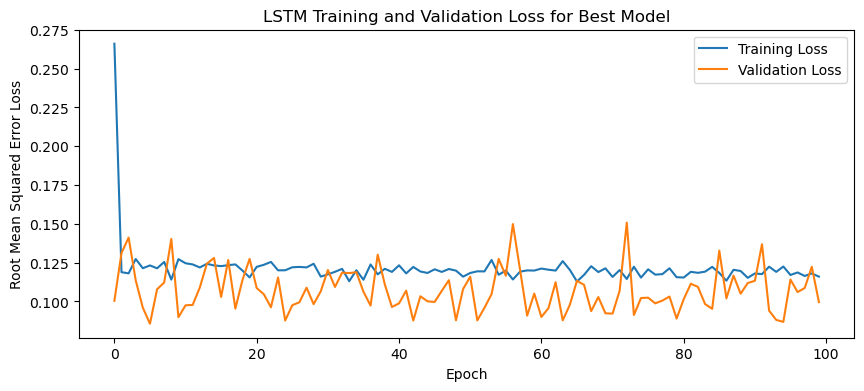

1/1 - 2s - loss: 0.1261 - 2s/epoch - 2s/step
Test Loss: 0.12614619731903076
Fold 2:
Epoch 1/100
19/19 [==============================] - 15s 240ms/step - loss: 0.2966 - val_loss: 0.0882
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1132 - val_loss: 0.1064
Epoch 3/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1081 - val_loss: 0.0903
Epoch 4/100
19/19 [==============================] - 1s 37ms/step - loss: 0.1065 - val_loss: 0.1224
Epoch 5/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1149 - val_loss: 0.0745
Epoch 6/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1121 - val_loss: 0.0710
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1087 - val_loss: 0.0899
Epoch 8/100
19/19 [==============================] - 1s 37ms/step - loss: 0.1077 - val_loss: 0.1025
Epoch 9/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1064 - val_loss: 0.0917
Epoch 10/100
1

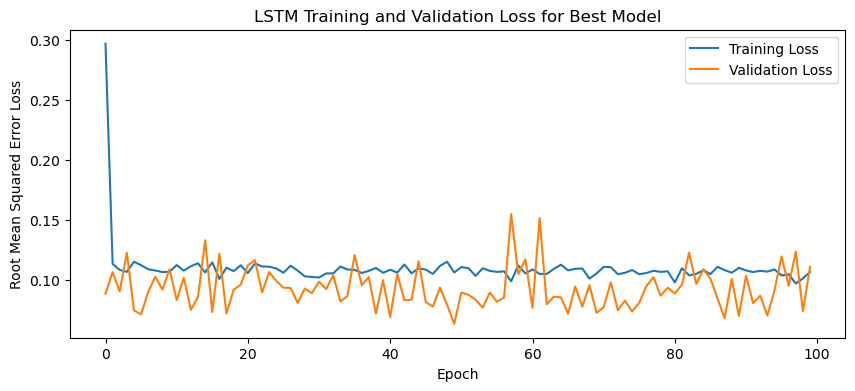

1/1 - 3s - loss: 0.0979 - 3s/epoch - 3s/step
Test Loss: 0.09787473827600479
Fold 3:
Epoch 1/100
19/19 [==============================] - 7s 156ms/step - loss: 0.3047 - val_loss: 0.0922
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1181 - val_loss: 0.0843
Epoch 3/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1151 - val_loss: 0.0950
Epoch 4/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1131 - val_loss: 0.0947
Epoch 5/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1175 - val_loss: 0.0806
Epoch 6/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1168 - val_loss: 0.0740
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1145 - val_loss: 0.0736
Epoch 8/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1159 - val_loss: 0.0873
Epoch 9/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1146 - val_loss: 0.0937
Epoch 10/100
19

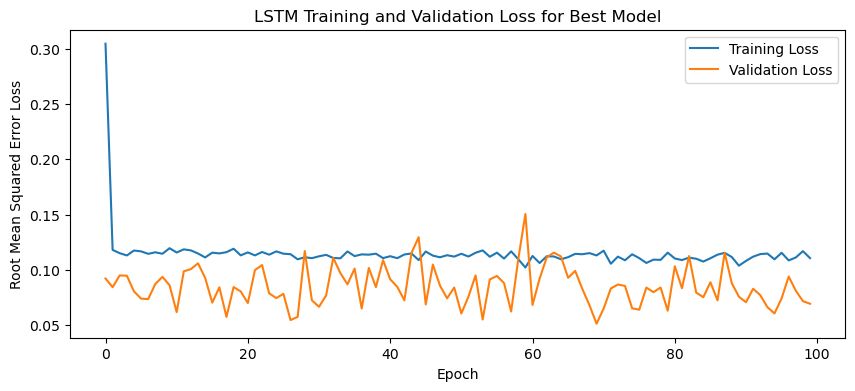

1/1 - 1s - loss: 0.0682 - 1s/epoch - 1s/step
Test Loss: 0.06822711229324341
Fold 4:
Epoch 1/100
20/20 [==============================] - 9s 188ms/step - loss: 0.3551 - val_loss: 0.0968
Epoch 2/100
20/20 [==============================] - 1s 38ms/step - loss: 0.1044 - val_loss: 0.1825
Epoch 3/100
20/20 [==============================] - 1s 38ms/step - loss: 0.1119 - val_loss: 0.1302
Epoch 4/100
20/20 [==============================] - 1s 36ms/step - loss: 0.1040 - val_loss: 0.1420
Epoch 5/100
20/20 [==============================] - 1s 29ms/step - loss: 0.1078 - val_loss: 0.1560
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1040 - val_loss: 0.1185
Epoch 7/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1074 - val_loss: 0.1169
Epoch 8/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1027 - val_loss: 0.1289
Epoch 9/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1037 - val_loss: 0.1190
Epoch 10/100
20

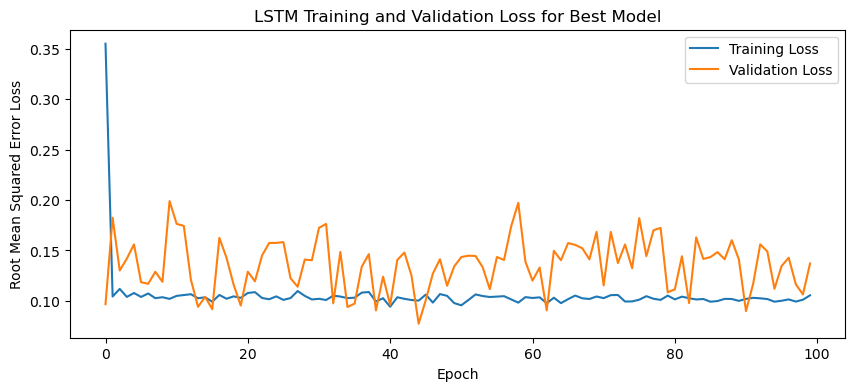

1/1 - 1s - loss: 0.1043 - 1s/epoch - 1s/step
Test Loss: 0.10429508984088898
Fold 5:
Epoch 1/100
19/19 [==============================] - 10s 92ms/step - loss: 0.4620 - val_loss: 0.1509
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1064 - val_loss: 0.1299
Epoch 3/100
19/19 [==============================] - 1s 31ms/step - loss: 0.1028 - val_loss: 0.1782
Epoch 4/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1040 - val_loss: 0.1900
Epoch 5/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1008 - val_loss: 0.1614
Epoch 6/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1036 - val_loss: 0.1733
Epoch 7/100
19/19 [==============================] - 1s 28ms/step - loss: 0.1070 - val_loss: 0.1494
Epoch 8/100
19/19 [==============================] - 1s 28ms/step - loss: 0.1078 - val_loss: 0.1518
Epoch 9/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1029 - val_loss: 0.1655
Epoch 10/100
19

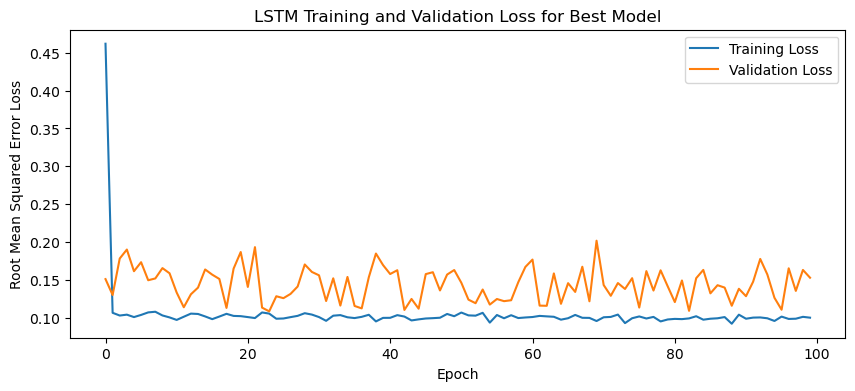

1/1 - 1s - loss: 0.0733 - 1s/epoch - 1s/step
Test Loss: 0.07333800941705704


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

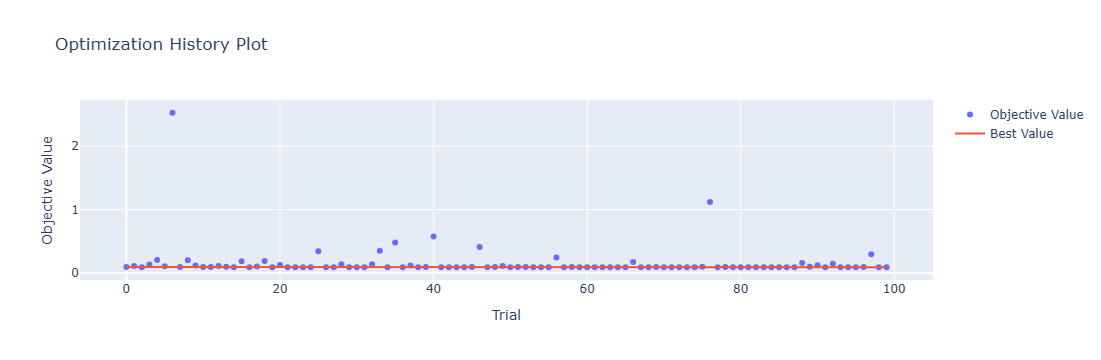

In [4]:
optuna.visualization.plot_optimization_history(study)

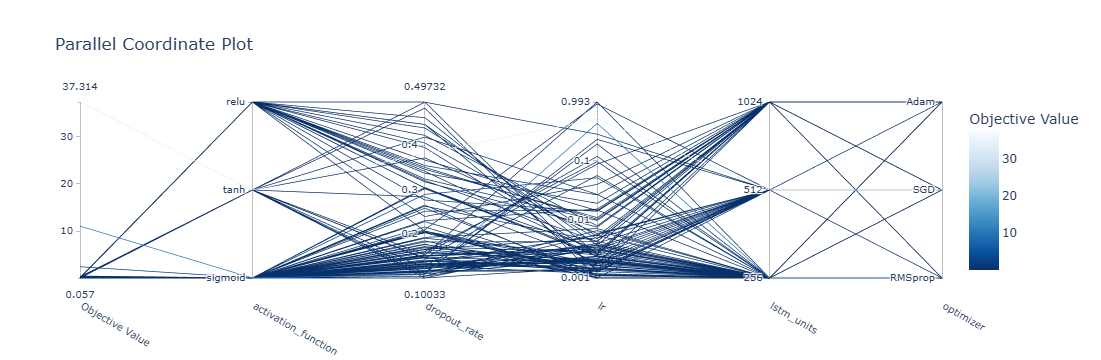

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

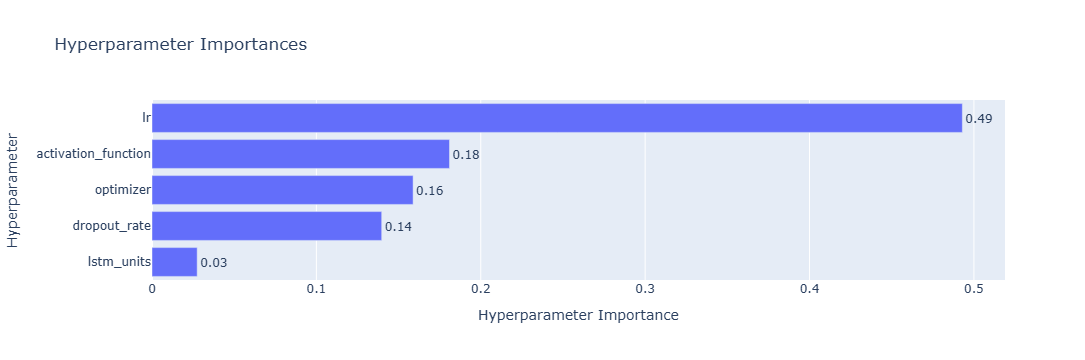

In [6]:
optuna.visualization.plot_param_importances(study)

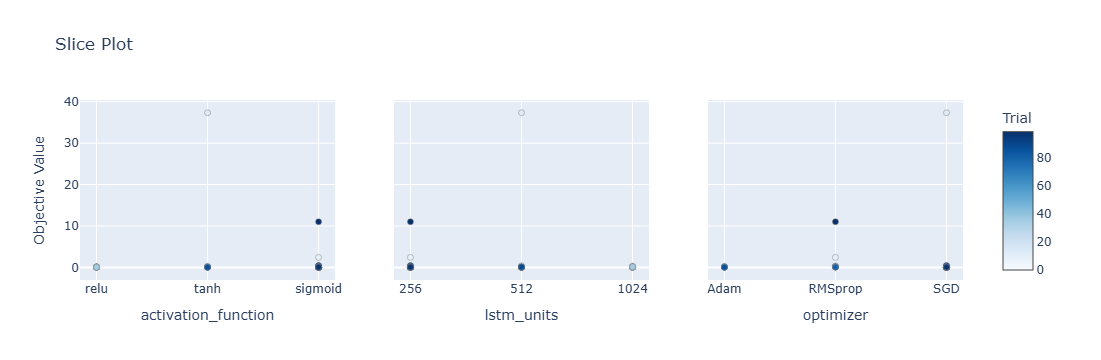

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

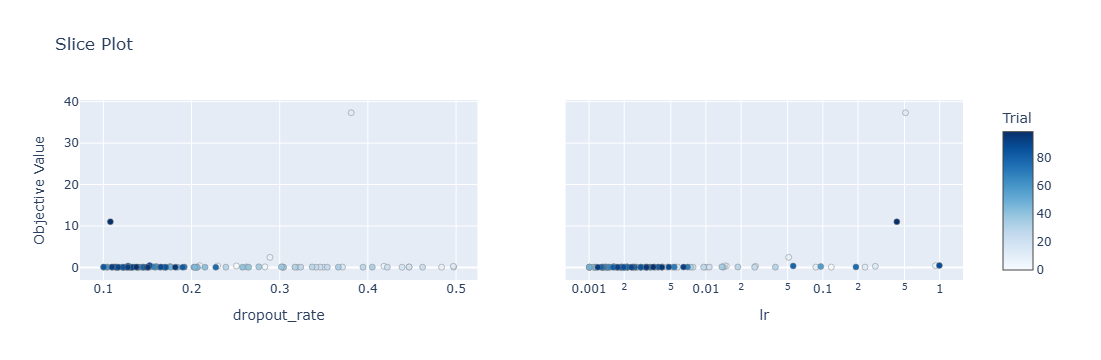

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 20s 329ms/step - loss: 0.9620 - accuracy: 0.1053 - mae: 0.7892 - rmse: 0.9620 - mape: 144.4938 - pearson: 0.1459 - val_loss: 0.8285 - val_accuracy: 0.0000e+00 - val_mae: 0.6737 - val_rmse: 0.8285 - val_mape: 123.2984 - val_pearson: 0.1885
Epoch 2/100
19/19 [==============================] - 1s 30ms/step - loss: 0.7092 - accuracy: 0.1053 - mae: 0.5833 - rmse: 0.7092 - mape: 105.8618 - pearson: 0.1609 - val_loss: 0.5774 - val_accuracy: 0.0000e+00 - val_mae: 0.4681 - val_rmse: 0.5774 - val_mape: 85.3662 - val_pearson: 0.2080
Epoch 3/100
19/19 [==============================] - 1s 32ms/step - loss: 0.4633

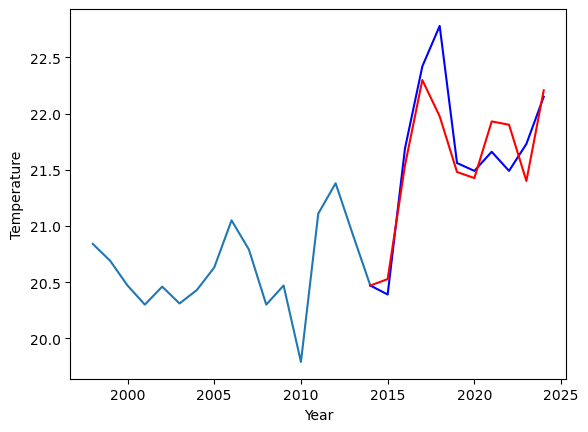

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.26		-0.11
17.64		17.27		-0.37
17.80		18.03		0.23
18.04		17.70		-0.34
18.00		17.21		-0.79
18.95		17.15		-1.80
18.12		17.66		-0.46
17.61		17.63		0.02
17.89		17.13		-0.76
17.72		17.93		0.21


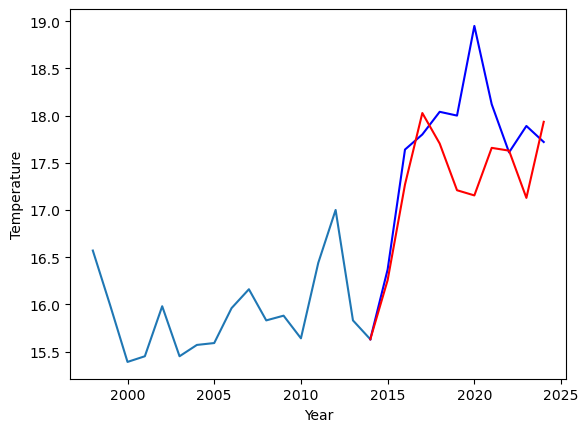

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.526790
1                1   16.37  16.256963


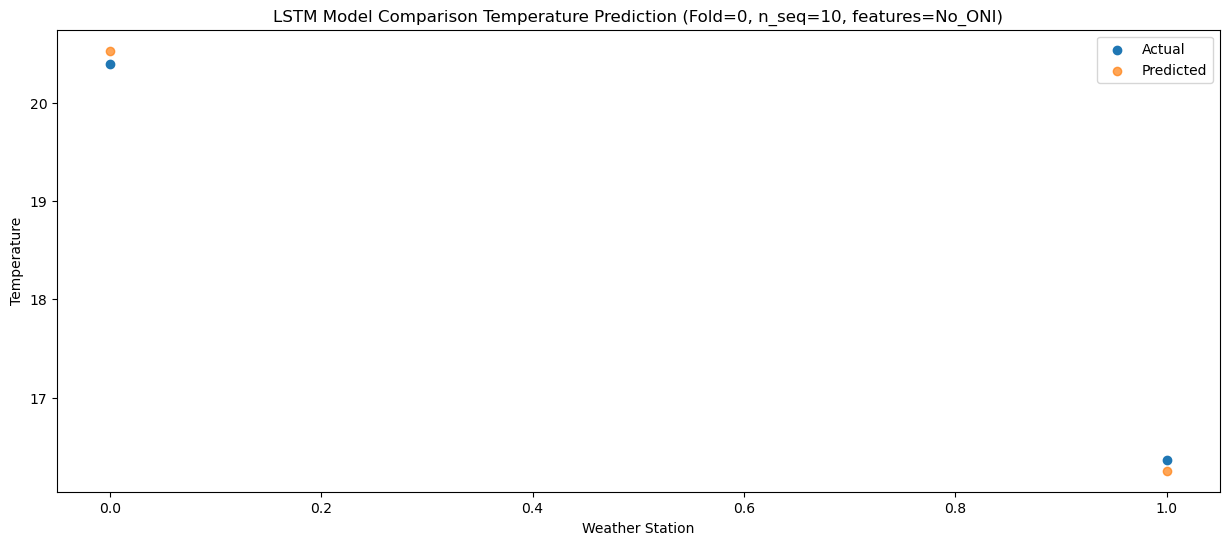

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  21.540541
1                1   17.64  17.269785


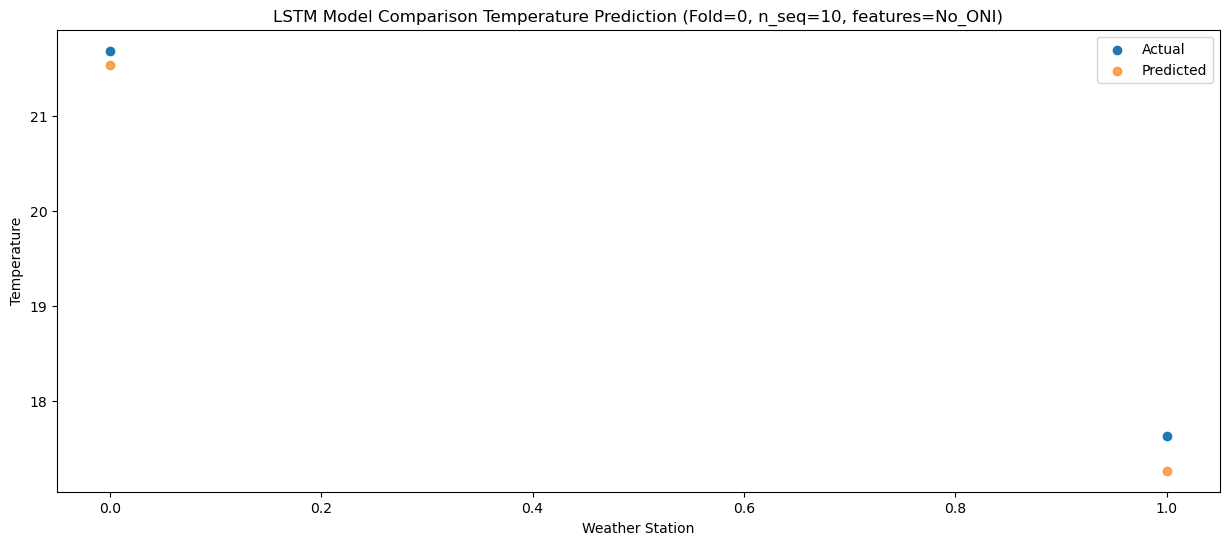

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.298468
1                1   17.80  18.027011


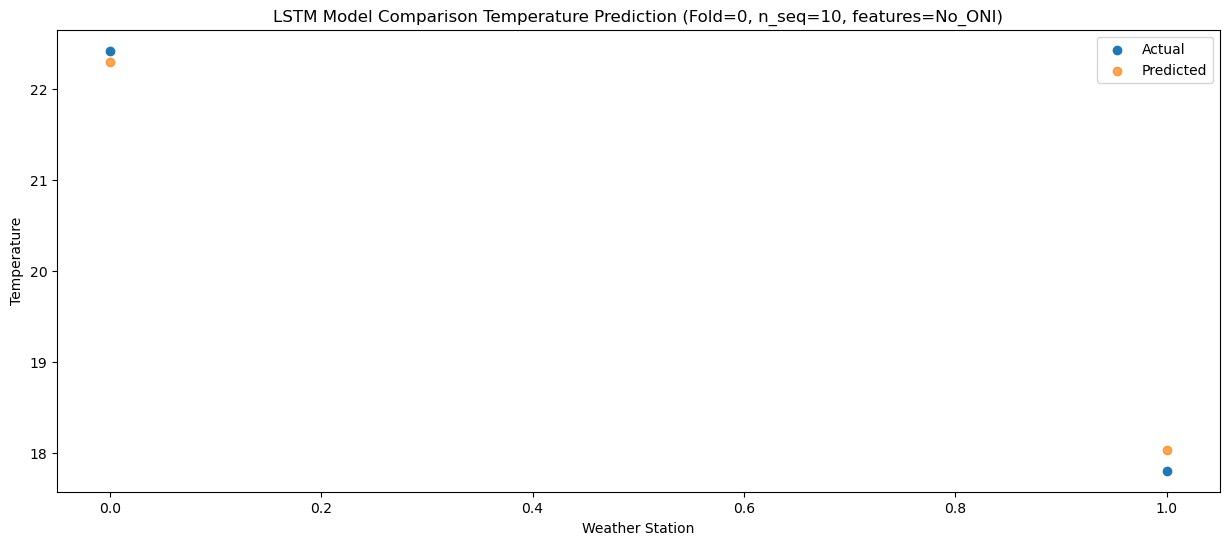

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  21.975682
1                1   18.04  17.704010


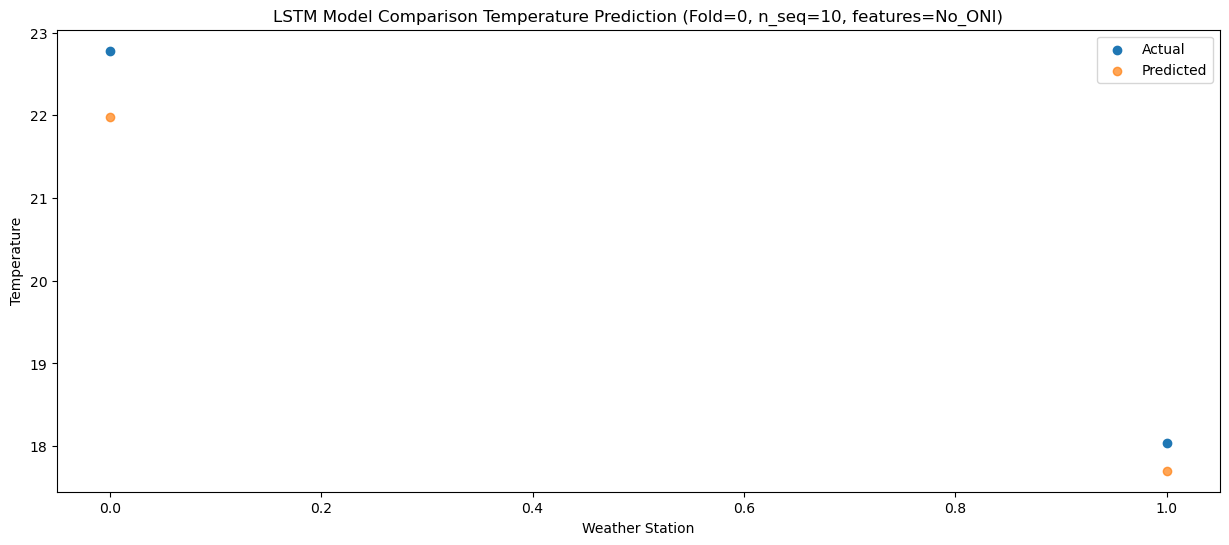

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.479870
1                1   18.00  17.209021


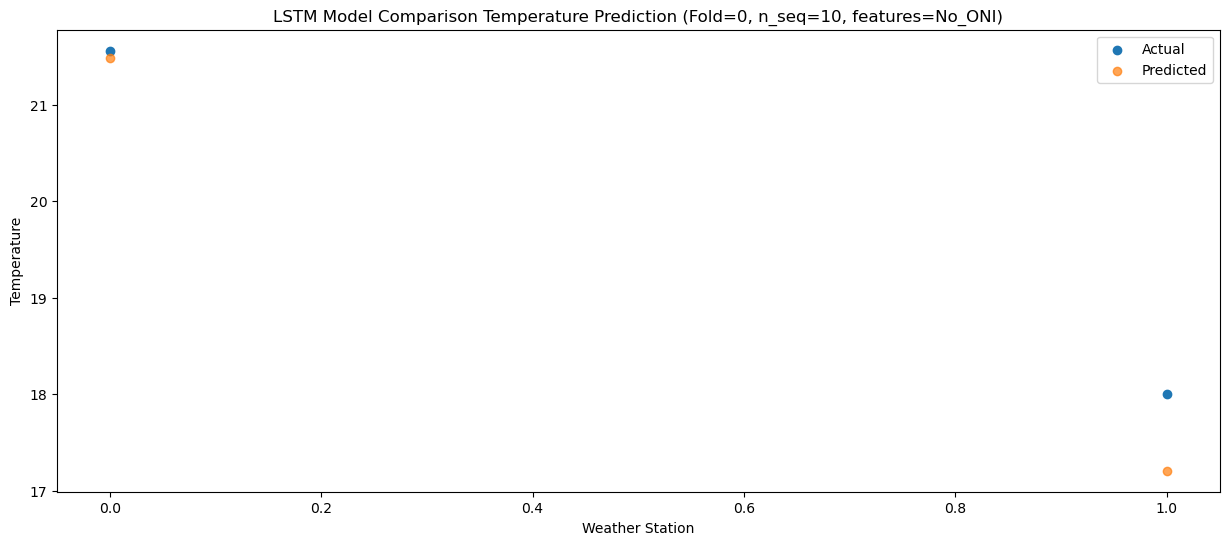

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.426155
1                1   18.95  17.154235


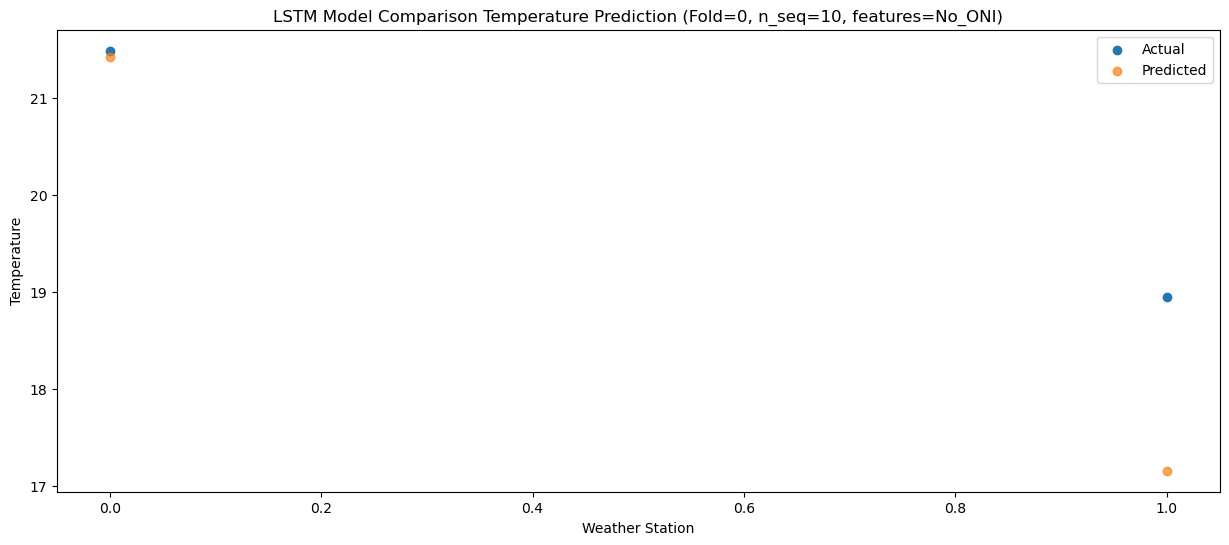

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  21.930135
1                1   18.12  17.658002


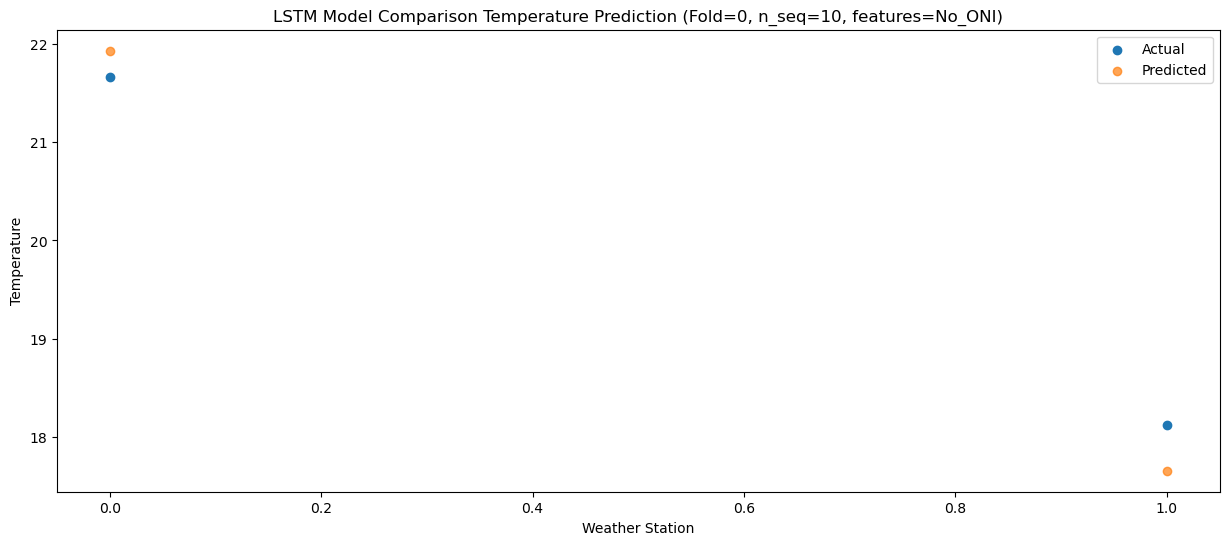

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  21.900700
1                1   17.61  17.628599


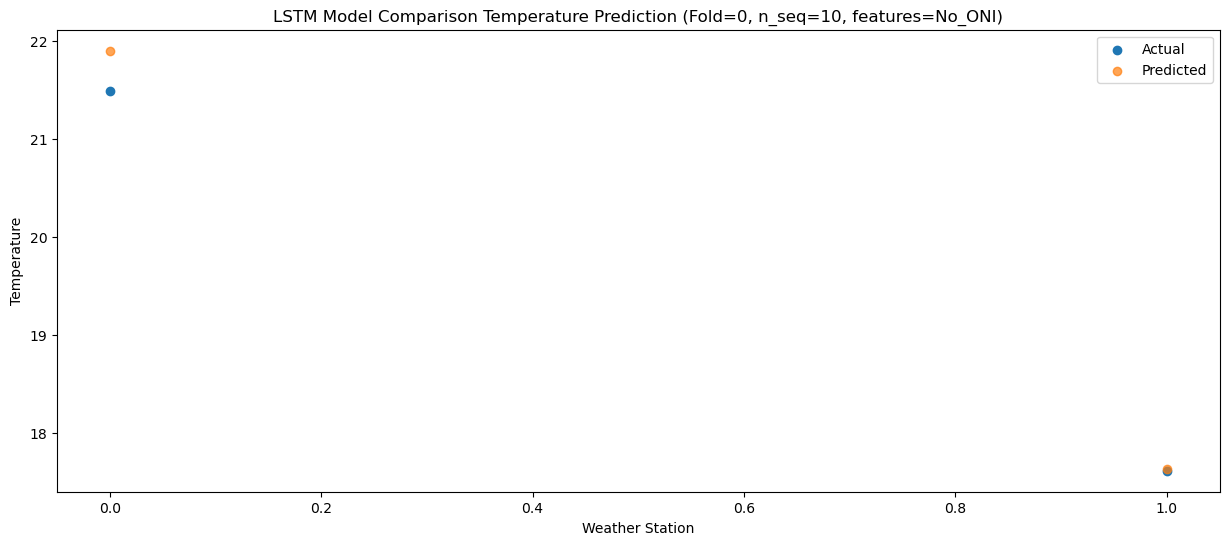

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.400696
1                1   17.89  17.128023


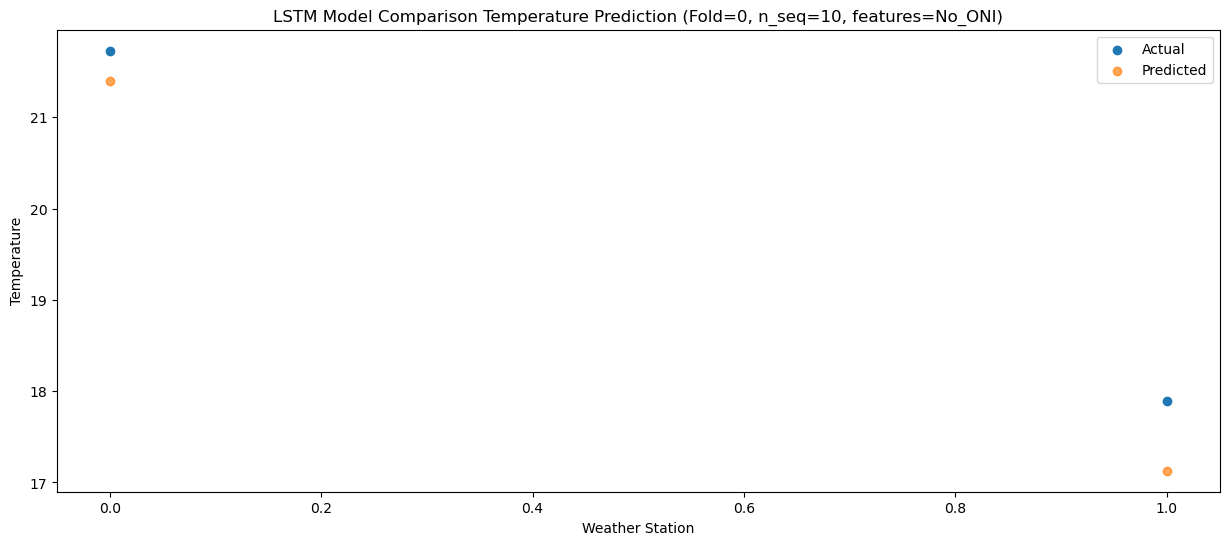

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15   22.20728
1                1   17.72   17.93405


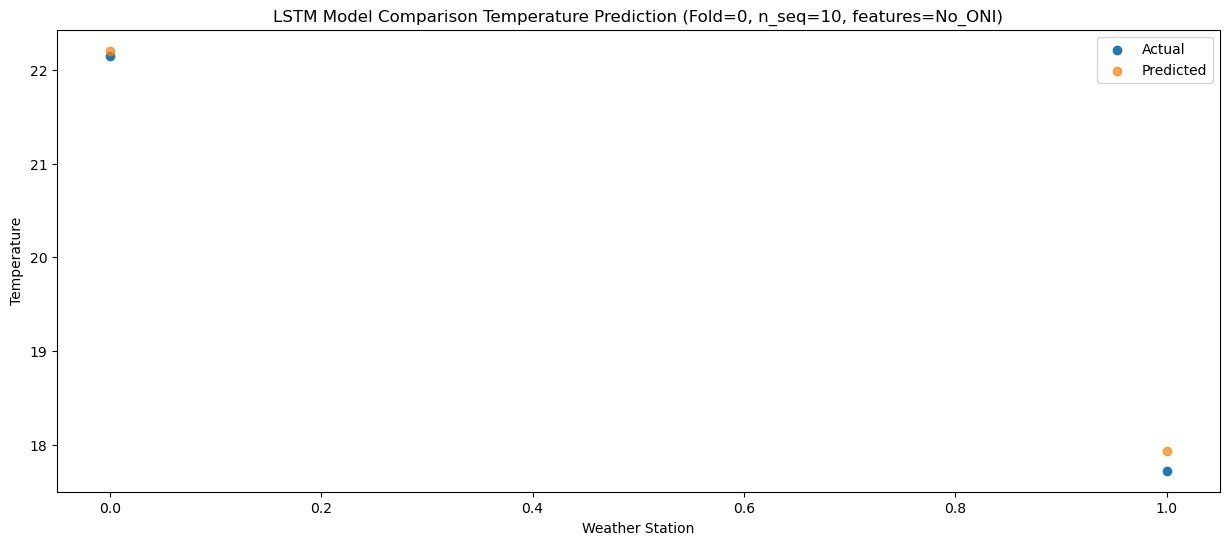

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.52679047 16.25696338]
 [21.54054126 17.26978505]
 [22.29846754 18.02701092]
 [21.97568181 17.70401031]
 [21.47987017 17.20902068]
 [21.42615523 17.15423548]
 [21.93013485 17.65800243]
 [21.9006997  17.62859865]
 [21.400696   17.12802257]
 [22.20727958 17.93404986]]
Year at t+1:
t+1 SKRMSE: 0.125477
t+1 KRMSE: 0.125477
t+1 MAE: 0.124914
t+1 SKMAPE: 0.006807
t+1 R2_SCORE: 0.996103
t+1 KMAPE: 0.006807
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.282309
t+2 KRMSE: 0.282309
t+2 MAE: 0.259837
t+2 SKMAPE: 0.013939
t+2 R2_SCORE: 0.980564
t+2 KMAPE: 0.013939
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.182077
t+3 KRMSE: 0.182077
t+3 MAE: 0.174272
t+3 SKMAPE: 0.009087
t+3 R2_SCORE: 0.993787
t+3 KMAPE: 0.009087
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.616367
t+4 KRMSE: 0.616367
t+4 MAE: 0.570154
t+4 SKMAPE: 0.026966
t+4 R

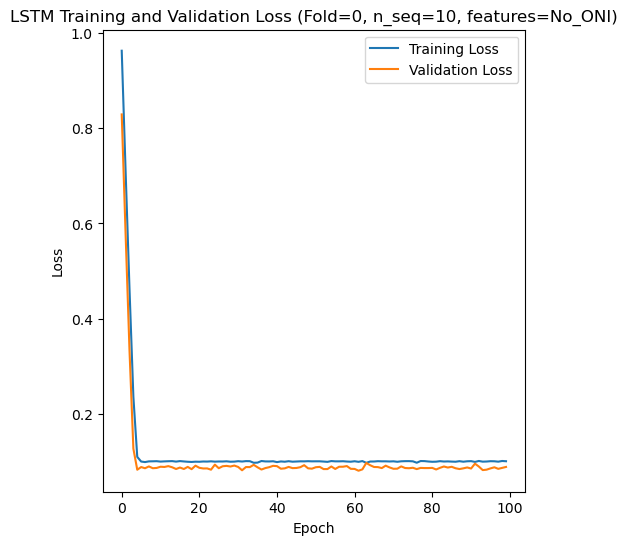

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 20s 285ms/step - loss: 0.8363 - accuracy: 0.1053 - mae: 0.7186 - rmse: 0.8363 - mape: 114.5883 - pearson: 0.0714 - val_loss: 0.6983 - val_accuracy: 0.0000e+00 - val_mae: 0.6028 - val_rmse: 0.6983 - val_mape: 96.1904 - val_pearson: 0.0550
Epoch 2/100
19/19 [==============================] - 1s 76ms/step - loss: 0.5870 - accuracy: 0.1053 - mae: 0.5026 - rmse: 0.5870 - mape: 79.4455 - pearson: 0.0864 - val_loss: 0.4505 - val_accuracy: 0.0000e+00 - val_mae: 0.3896 - val_rmse: 0.4505 - val_mape: 61.7196 - val_pearson: 0.0844
Epoch 3/100
19/19 [==============================] - 2s 120ms/step - loss: 0.3459 -

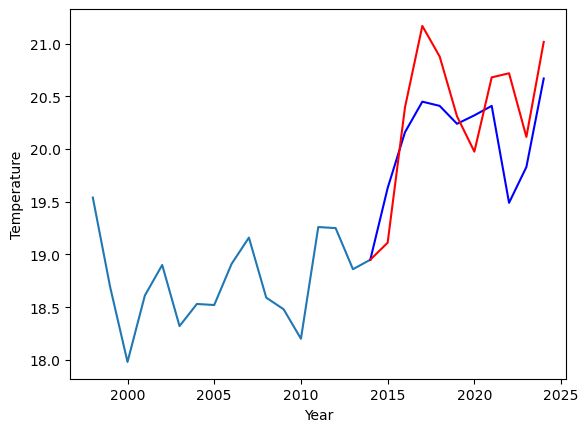

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.26		-0.62
19.40		20.55		1.15
20.43		21.32		0.89
20.81		21.04		0.23
19.96		20.47		0.51
20.09		20.13		0.04
20.61		20.84		0.23
20.22		20.88		0.66
20.22		20.28		0.06
21.53		21.18		-0.35


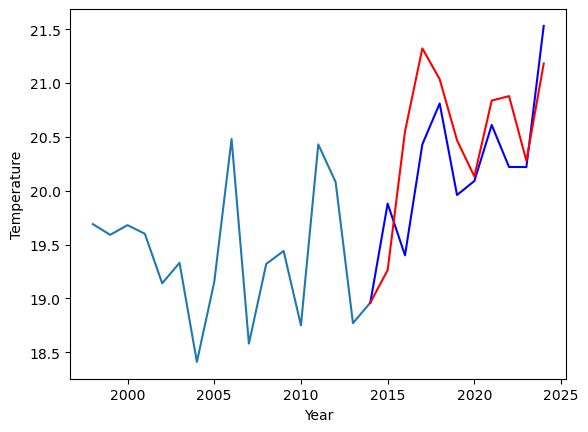

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  19.111363
1                1   19.88  19.262698


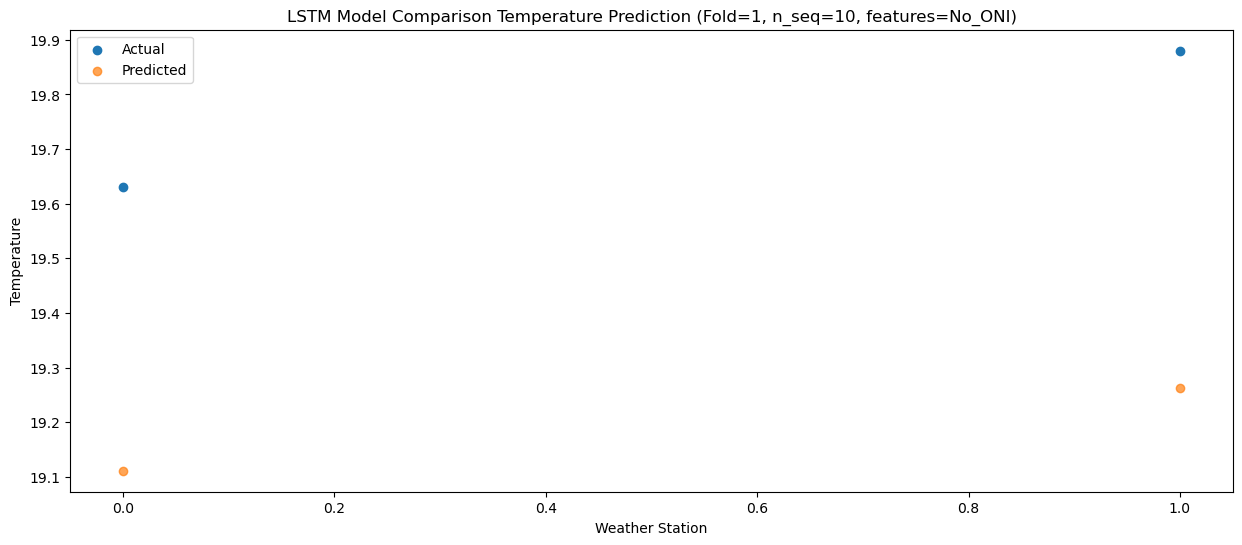

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  20.396470
1                1   19.40  20.549204


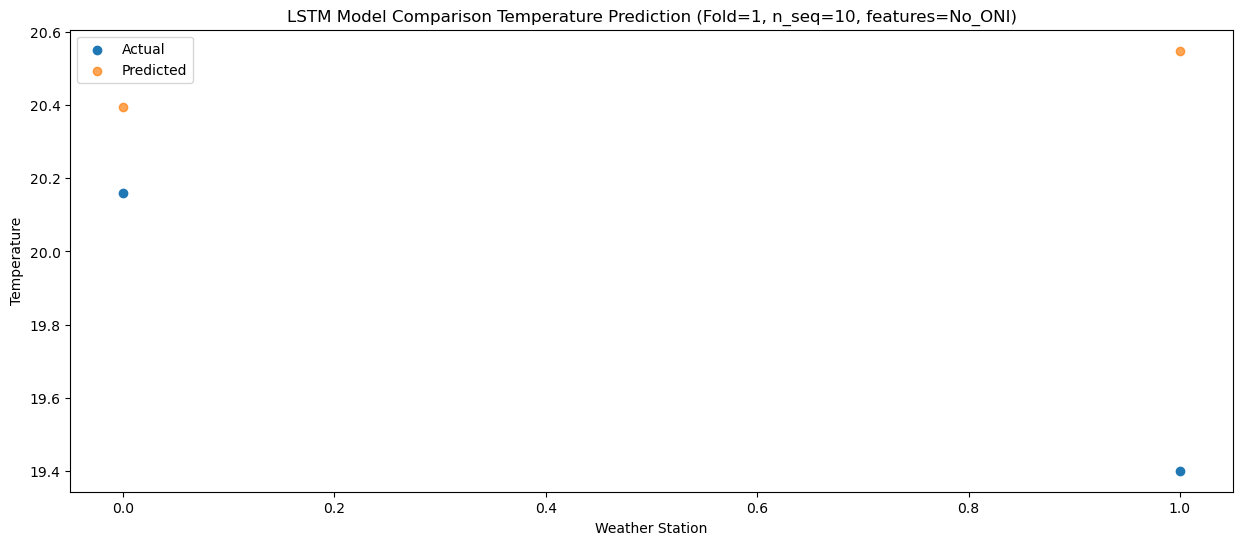

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  21.168868
1                1   20.43  21.321518


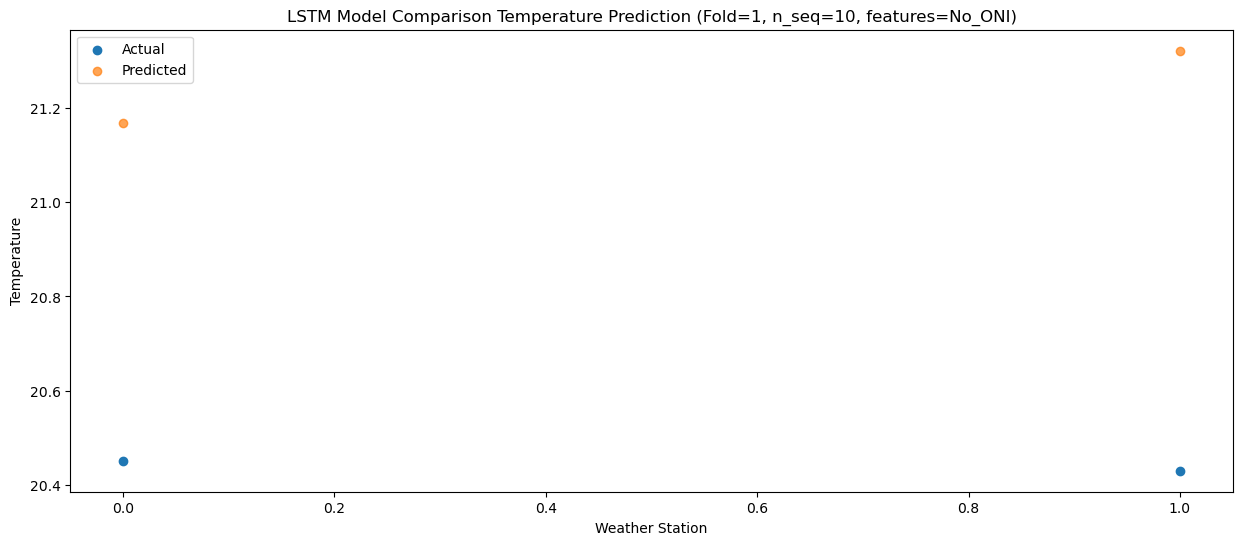

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  20.878184
1                1   20.81  21.035090


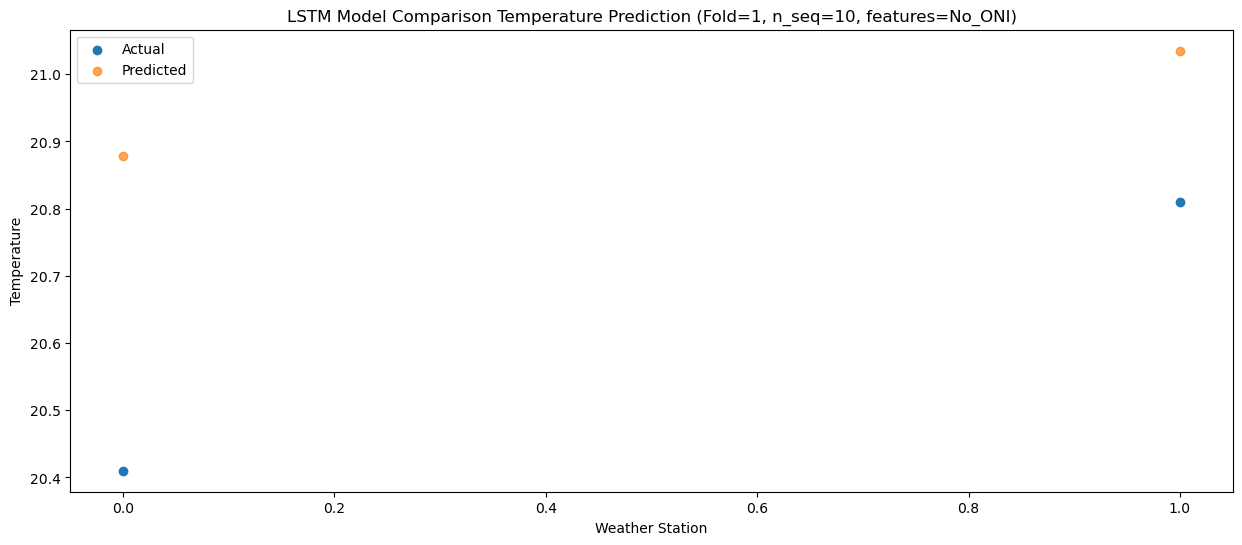

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  20.311059
1                1   19.96  20.468324


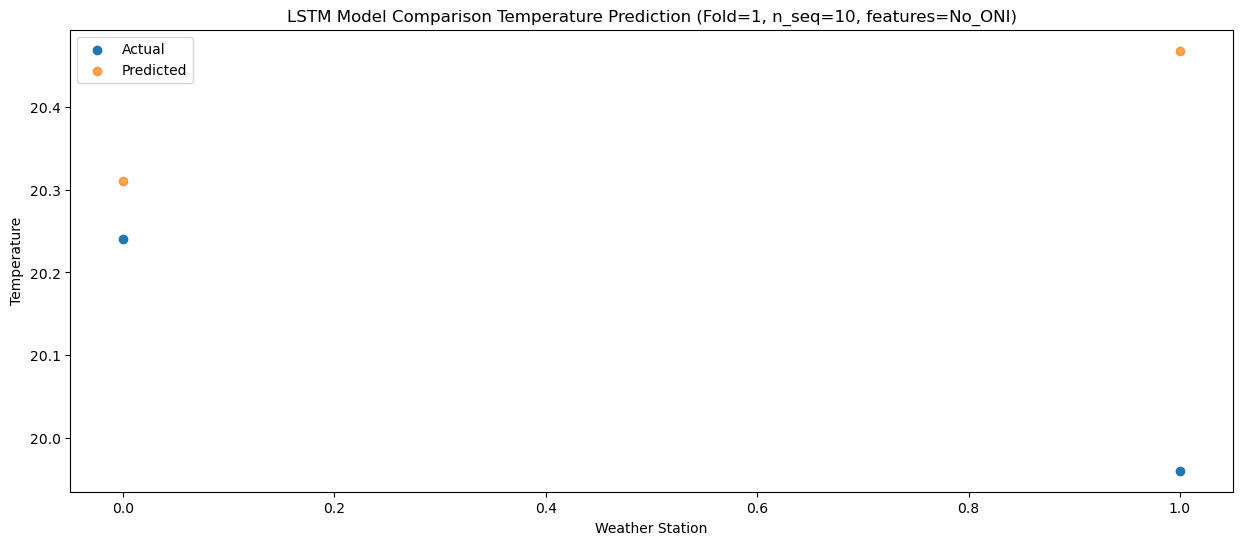

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  19.975739
1                1   20.09  20.132501


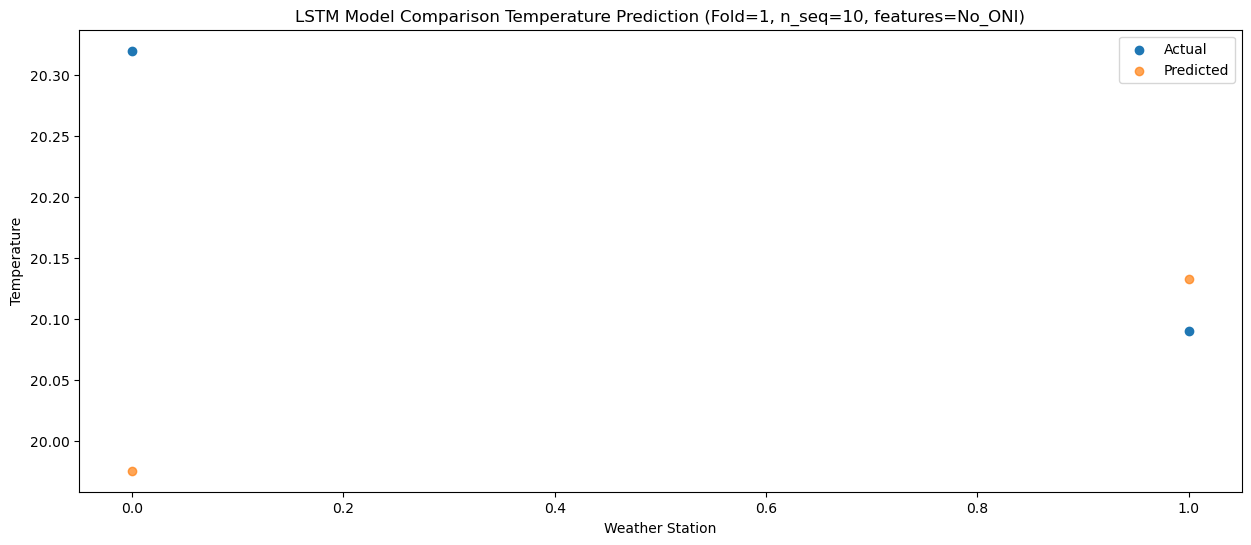

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  20.680501
1                1   20.61  20.837079


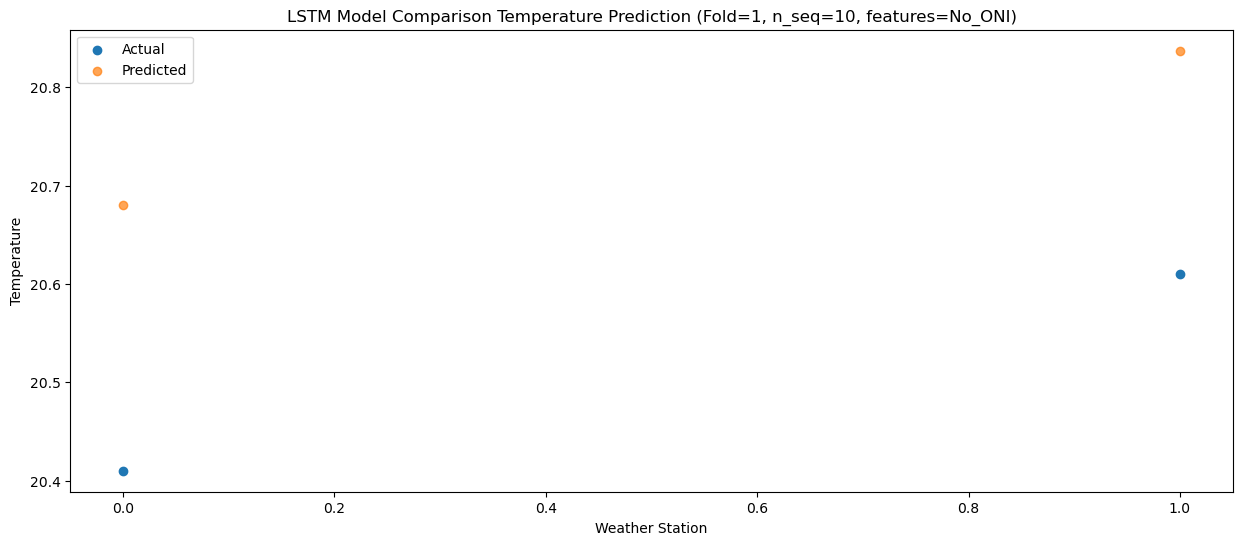

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  20.719504
1                1   20.22  20.878032


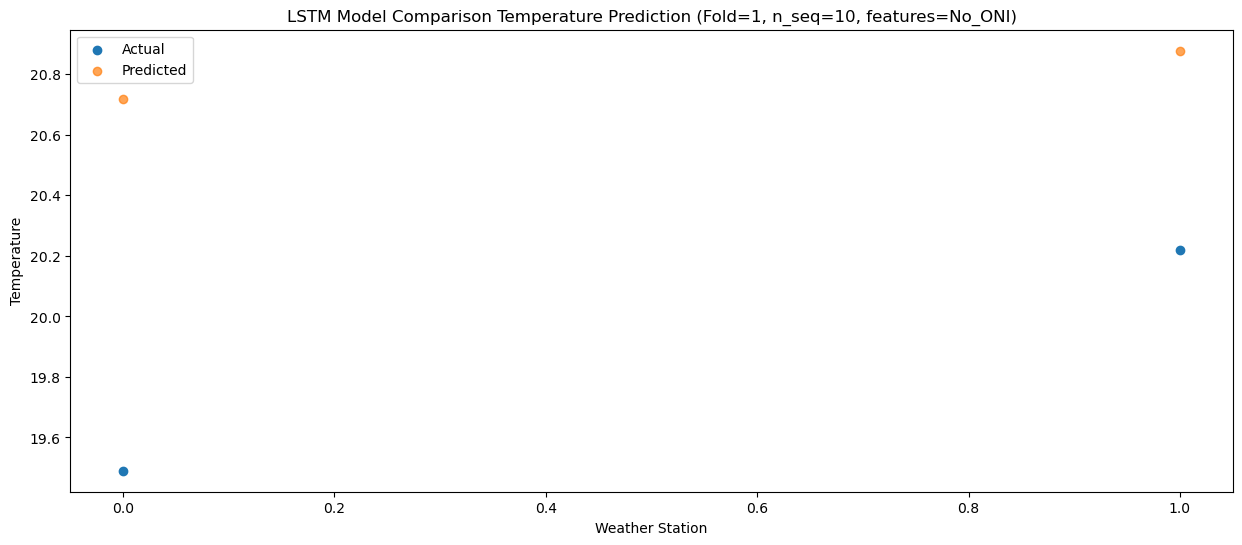

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  20.115496
1                1   20.22  20.277191


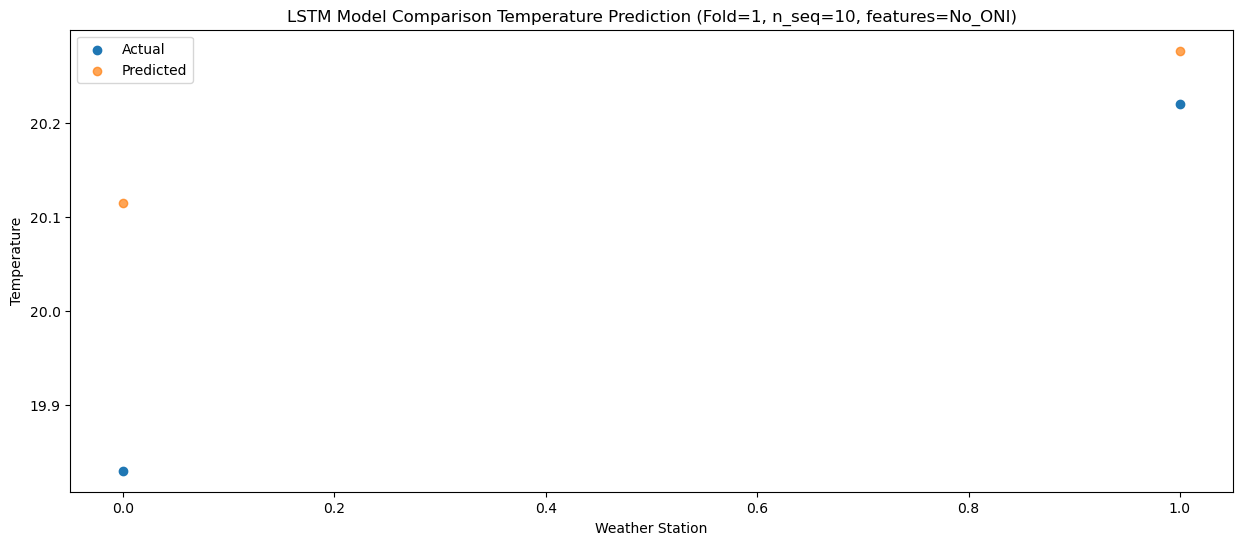

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  21.017248
1                1   21.53  21.180907


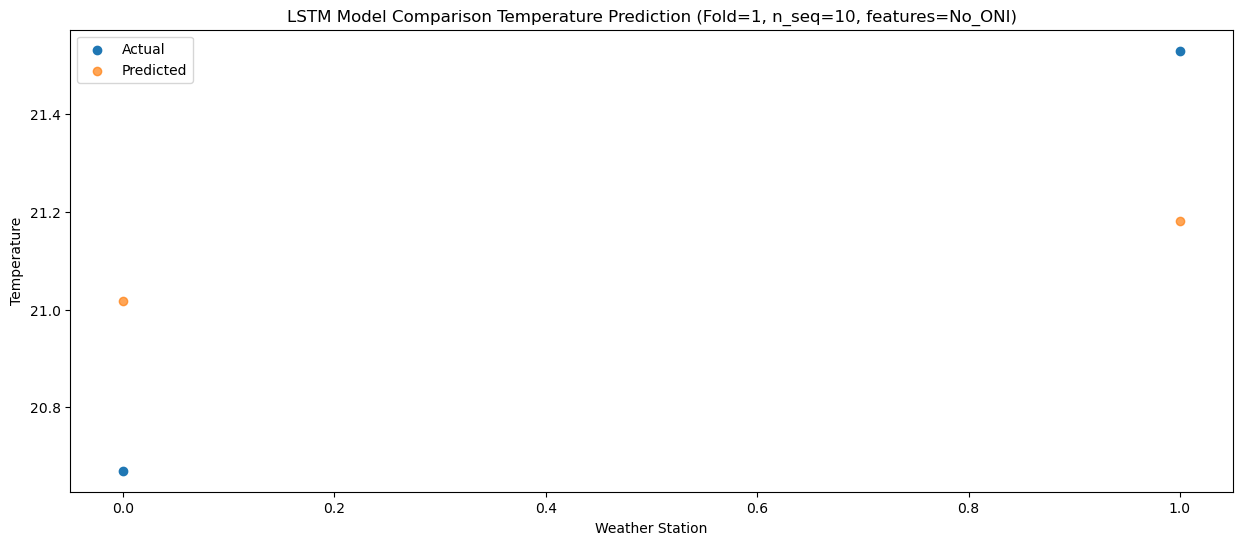

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[19.11136297 19.26269821]
 [20.39647035 20.54920414]
 [21.16886781 21.32151768]
 [20.87818439 21.03508961]
 [20.31105919 20.46832359]
 [19.97573862 20.13250119]
 [20.68050102 20.83707893]
 [20.71950416 20.87803203]
 [20.11549591 20.27719063]
 [21.01724778 21.18090713]]
Year at t+1:
t+1 SKRMSE: 0.570108
t+1 KRMSE: 0.570108
t+1 MAE: 0.567969
t+1 SKMAPE: 0.028736
t+1 R2_SCORE: -19.801468
t+1 KMAPE: 0.028736
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.829635
t+2 KRMSE: 0.829635
t+2 MAE: 0.692837
t+2 SKMAPE: 0.035484
t+2 R2_SCORE: -3.766580
t+2 KMAPE: 0.035484
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.809807
t+3 KRMSE: 0.809807
t+3 MAE: 0.805193
t+3 SKMAPE: 0.039395
t+3 R2_SCORE: -6556.873461
t+3 KMAPE: 0.039395
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.367330
t+4 KRMSE: 0.367330
t+4 MAE: 0.346637
t+4 SKMAPE: 0.01687

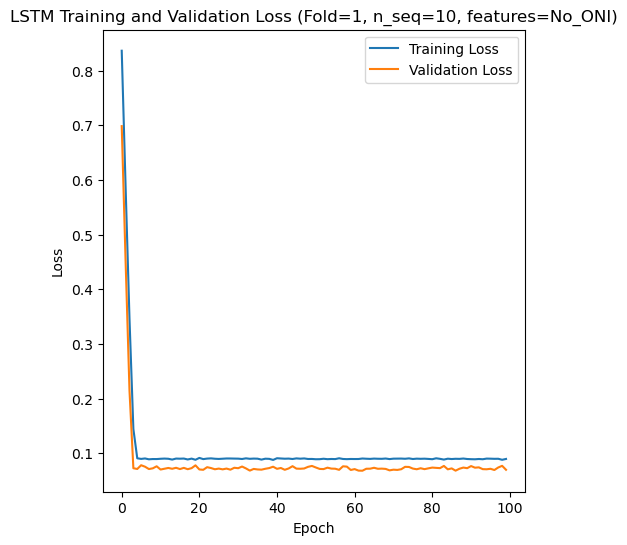

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 17s 225ms/step - loss: 0.6260 - accuracy: 0.0000e+00 - mae: 0.4815 - rmse: 0.6260 - mape: 77.3624 - pearson: 0.0724 - val_loss: 0.4958 - val_accuracy: 0.0000e+00 - val_mae: 0.3734 - val_rmse: 0.4958 - val_mape: 58.5305 - val_pearson: 0.0539
Epoch 2/100
19/19 [==============================] - 3s 167ms/step - loss: 0.3945 - accuracy: 0.0000e+00 - mae: 0.3045 - rmse: 0.3945 - mape: 48.4663 - pearson: 0.0714 - val_loss: 0.2662 - val_accuracy: 0.0000e+00 - val_mae: 0.1983 - val_rmse: 0.2662 - val_mape: 30.9820 - val_pearson: 0.0504
Epoch 3/100
19/19 [==============================] - 3s 141ms/step - loss: 

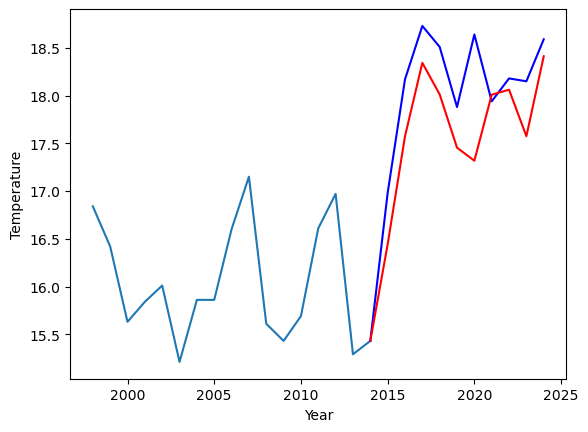

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.11		0.22
14.23		14.24		0.01
15.00		15.01		0.01
14.82		14.68		-0.14
14.35		14.12		-0.23
14.68		13.98		-0.70
14.67		14.67		0.00
14.66		14.72		0.06
14.20		14.24		0.04
14.99		15.08		0.09


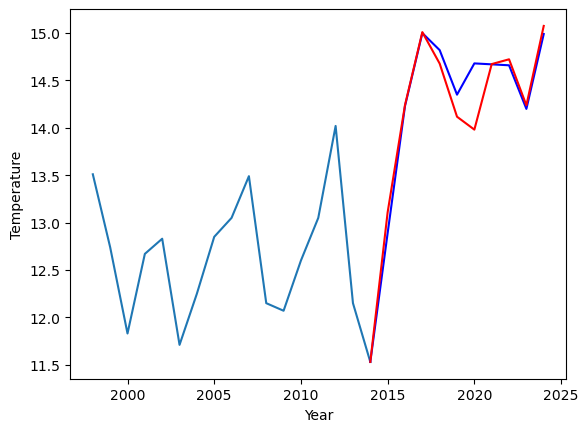

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.441225
1                1   12.89  13.109499


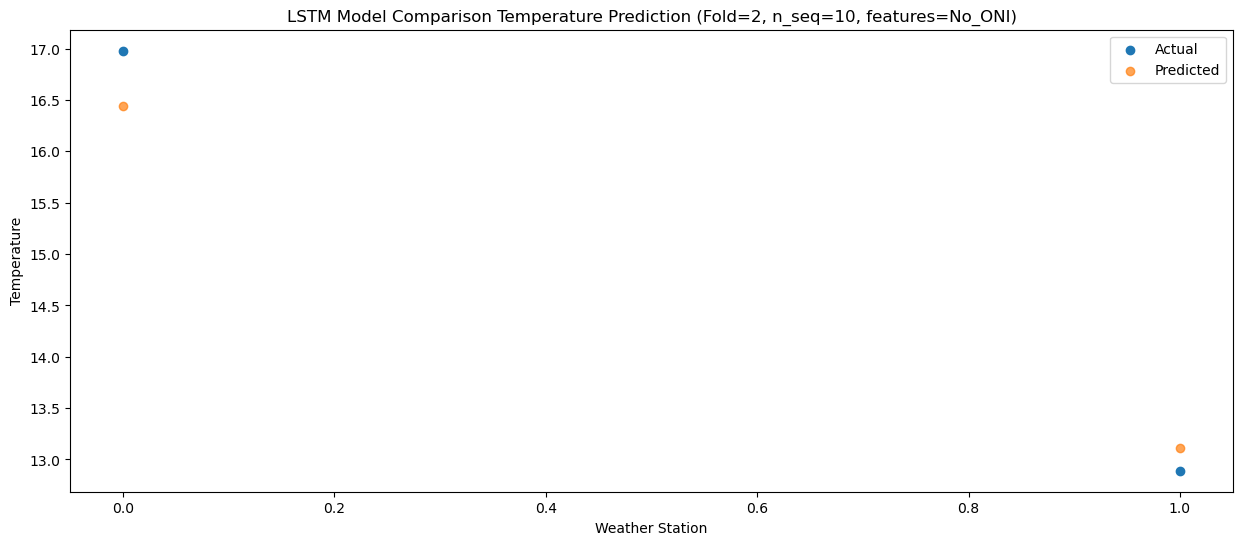

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.573895
1                1   14.23  14.240402


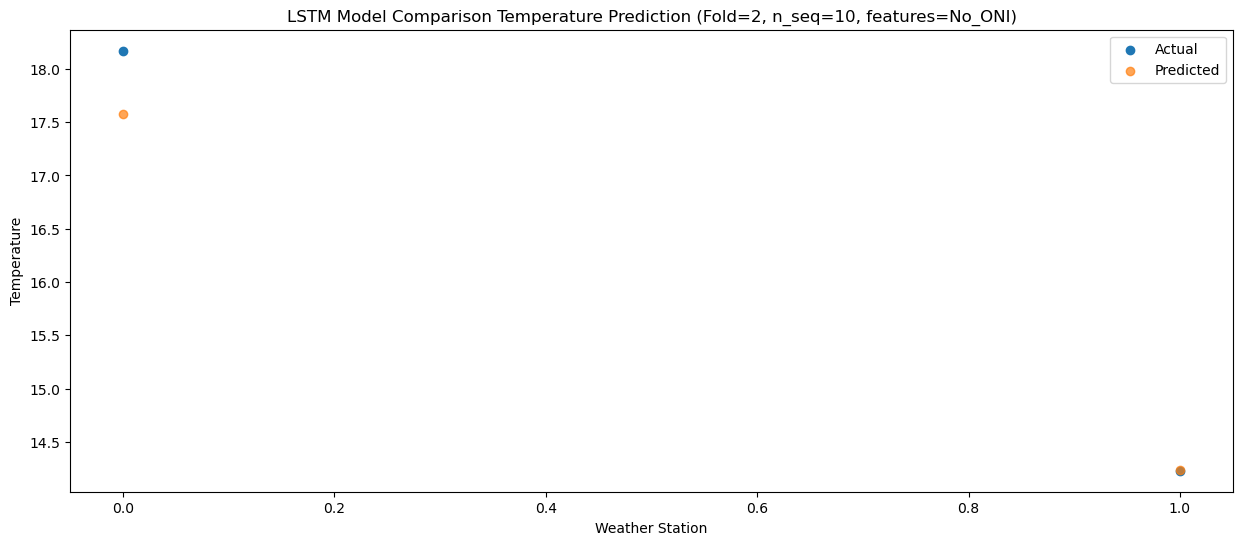

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.343402
1                1   15.00  15.010071


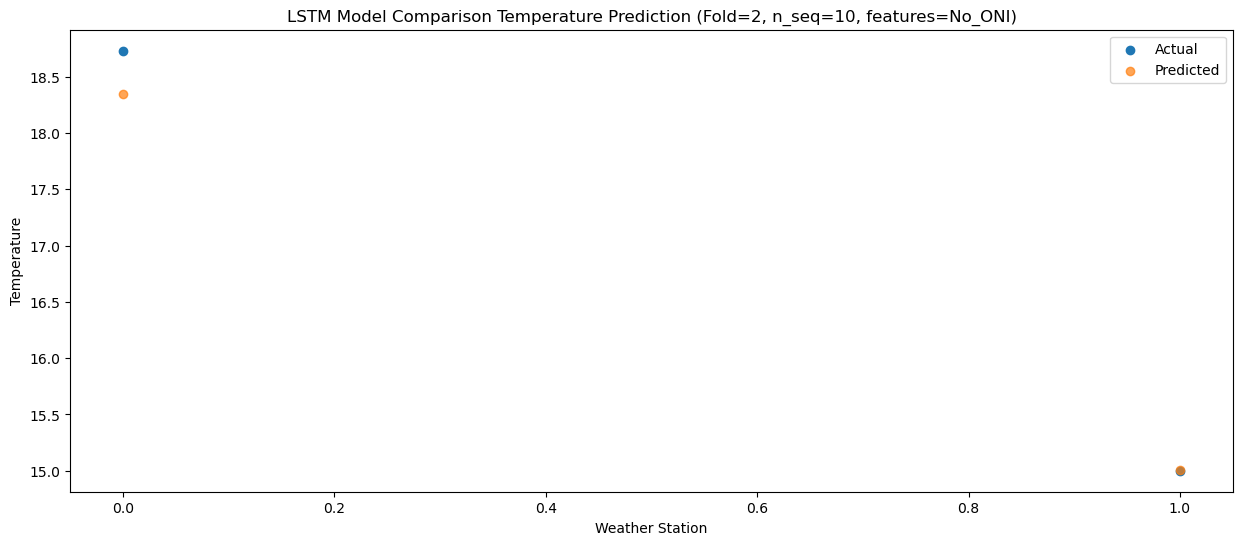

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.012837
1                1   14.82  14.677919


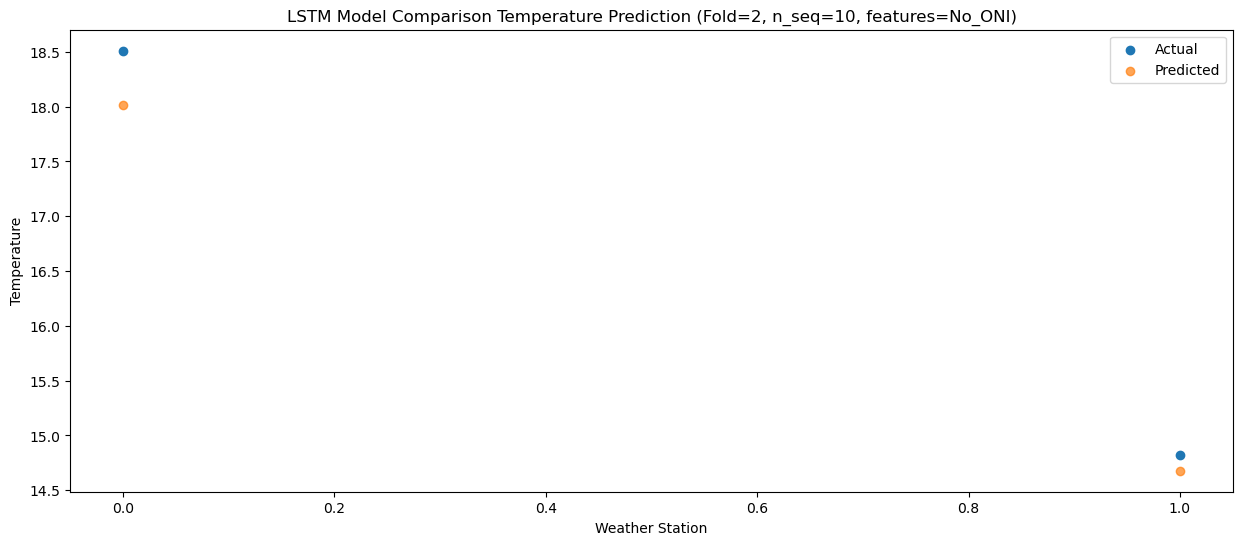

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  17.454550
1                1   14.35  14.117397


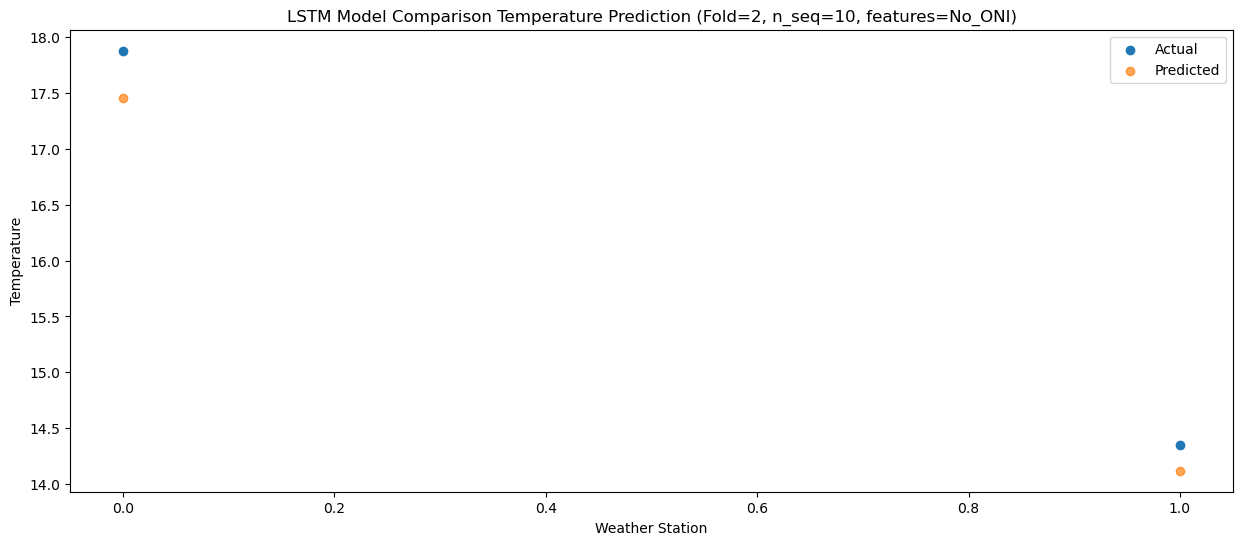

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  17.318081
1                1   14.68  13.981134


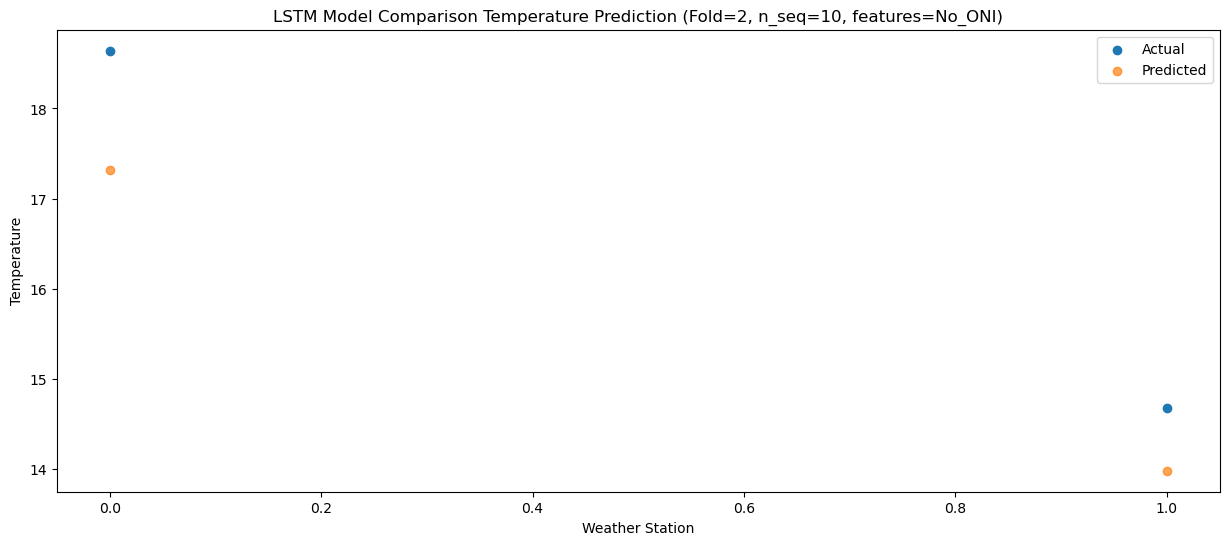

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  18.009496
1                1   14.67  14.672813


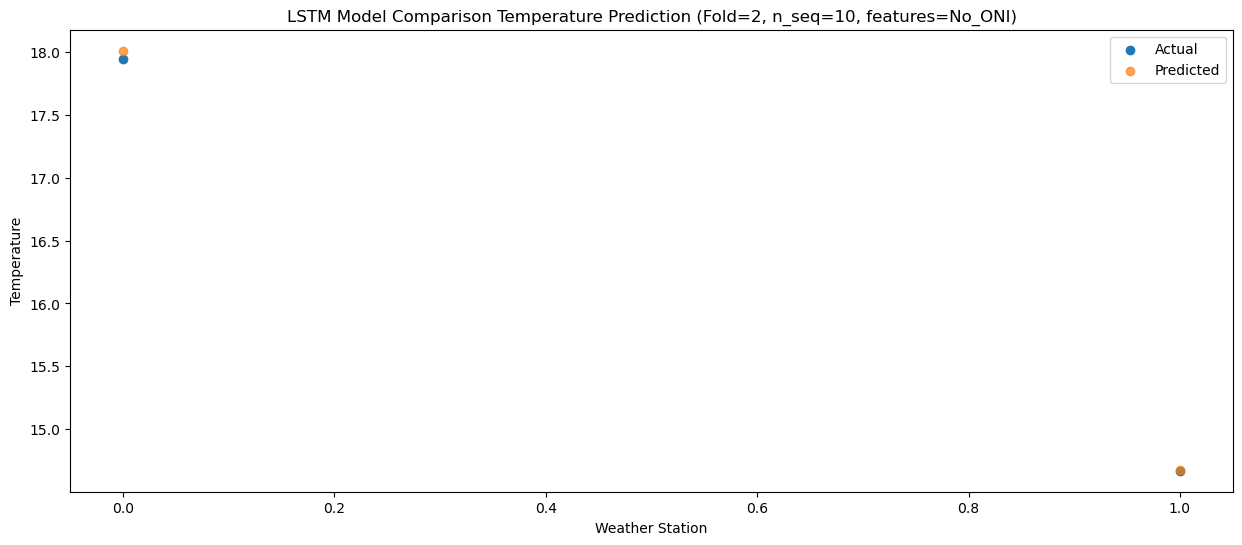

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  18.061718
1                1   14.66  14.723189


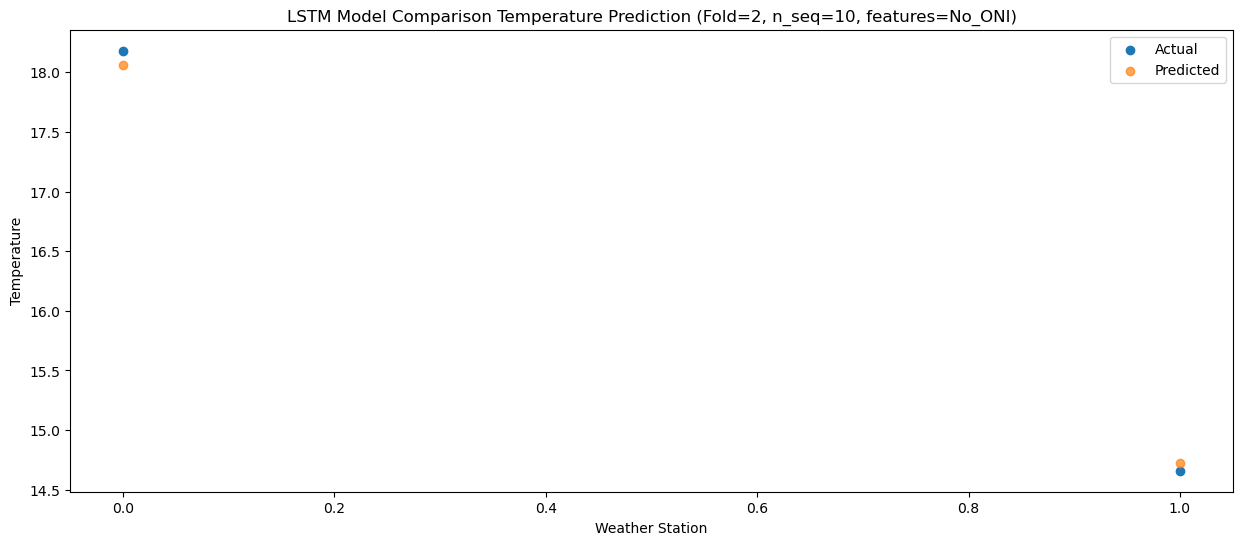

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  17.574363
1                1   14.20  14.237867


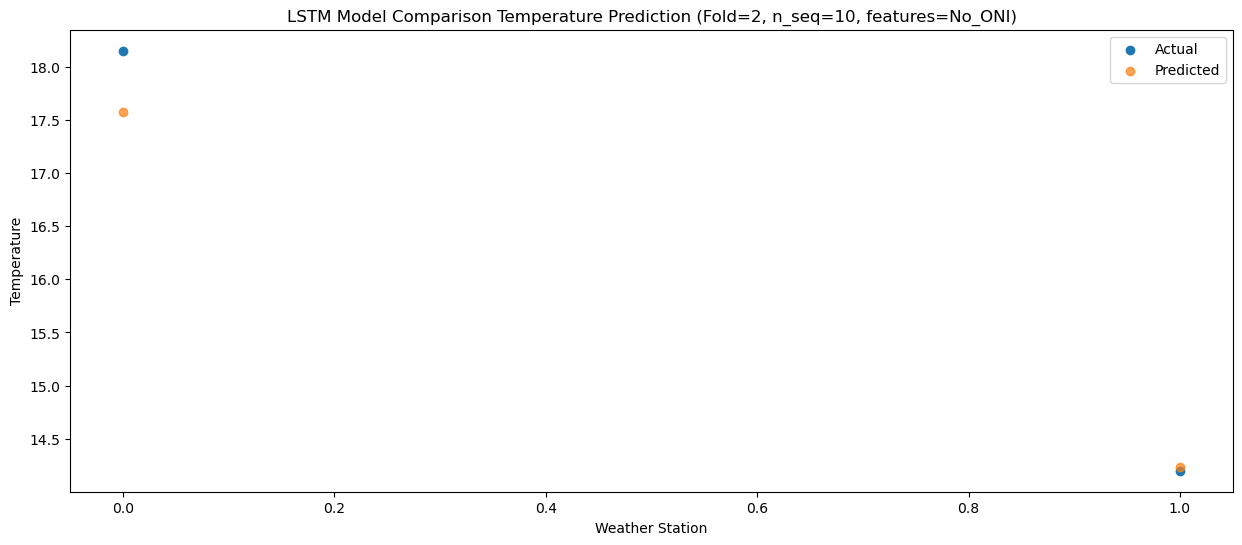

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  18.412178
1                1   14.99  15.075446


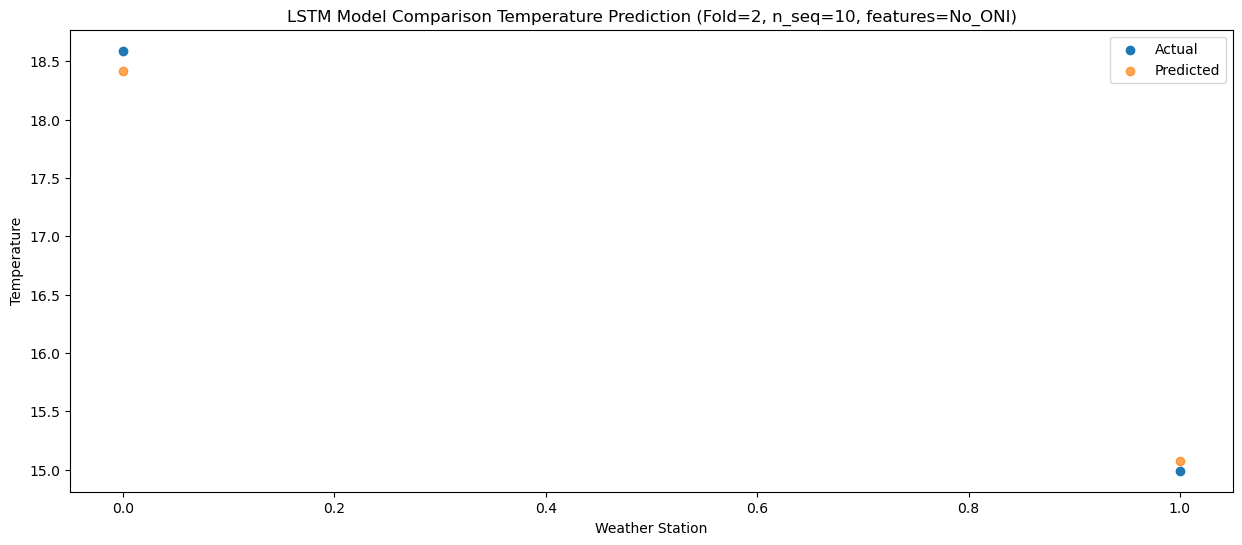

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.44122544 13.10949914]
 [17.57389453 14.24040155]
 [18.3434017  15.0100715 ]
 [18.01283666 14.67791904]
 [17.45455029 14.11739654]
 [17.31808149 13.98113377]
 [18.00949633 14.67281295]
 [18.06171824 14.72318938]
 [17.57436262 14.23786679]
 [18.41217832 15.07544586]]
Year at t+1:
t+1 SKRMSE: 0.411374
t+1 KRMSE: 0.411374
t+1 MAE: 0.379137
t+1 SKMAPE: 0.024379
t+1 R2_SCORE: 0.959534
t+1 KMAPE: 0.024379
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.421574
t+2 KRMSE: 0.421574
t+2 MAE: 0.303254
t+2 SKMAPE: 0.016769
t+2 R2_SCORE: 0.954205
t+2 KMAPE: 0.016769
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.273459
t+3 KRMSE: 0.273459
t+3 MAE: 0.198335
t+3 SKMAPE: 0.010656
t+3 R2_SCORE: 0.978501
t+3 KMAPE: 0.010656
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.365622
t+4 KRMSE: 0.365622
t+4 MAE: 0.319622
t+4 SKMAPE: 0.018223
t+4 R

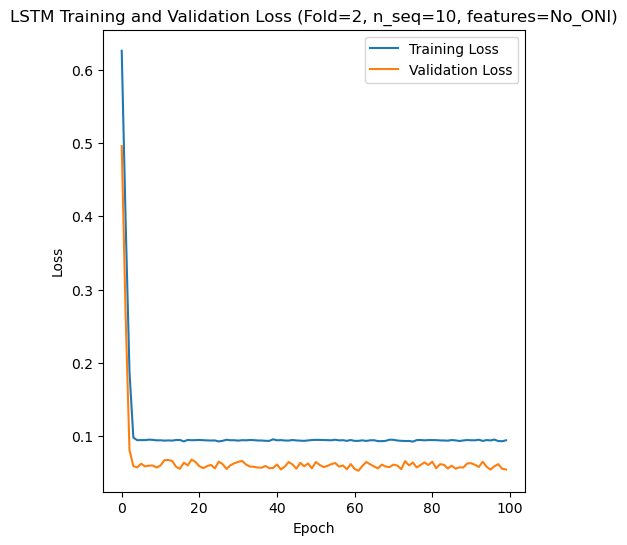

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 20s 320ms/step - loss: 1.1525 - accuracy: 0.1500 - mae: 1.0428 - rmse: 1.1525 - mape: 164.2377 - pearson: 0.0649 - val_loss: 1.0157 - val_accuracy: 0.0000e+00 - val_mae: 0.9300 - val_rmse: 1.0157 - val_mape: 149.4022 - val_pearson: 0.0618
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.8863 - accuracy: 0.1500 - mae: 0.7979 - rmse: 0.8863 - mape: 125.5291 - pearson: 0.0724 - val_loss: 0.7522 - val_accuracy: 0.0000e+00 - val_mae: 0.6871 - val_rmse: 0.7522 - val_mape: 110.0542 - val_pearson: 0.0811
Epoch 3/100
20/20 [==============================] - 2s 80ms/step - loss: 0.6241 

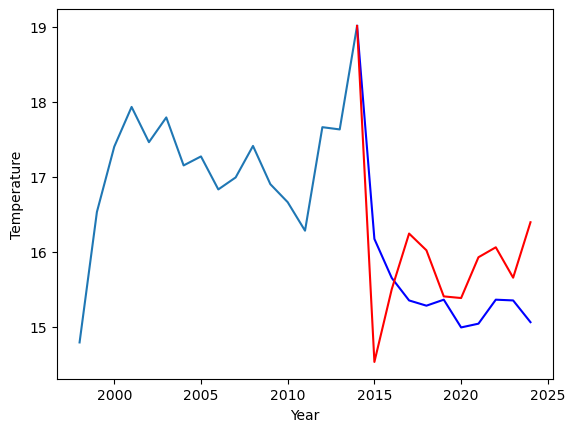

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.80		0.77
14.13		14.77		0.64
15.42		15.51		0.09
15.25		15.29		0.04
14.76		14.67		-0.09
15.17		14.65		-0.52
15.05		15.20		0.15
14.85		15.33		0.48
14.55		14.92		0.37
15.57		15.66		0.09


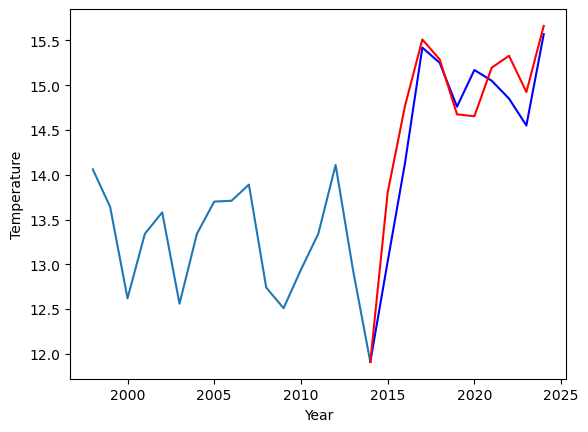

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.530142
1                1   13.03  13.799830


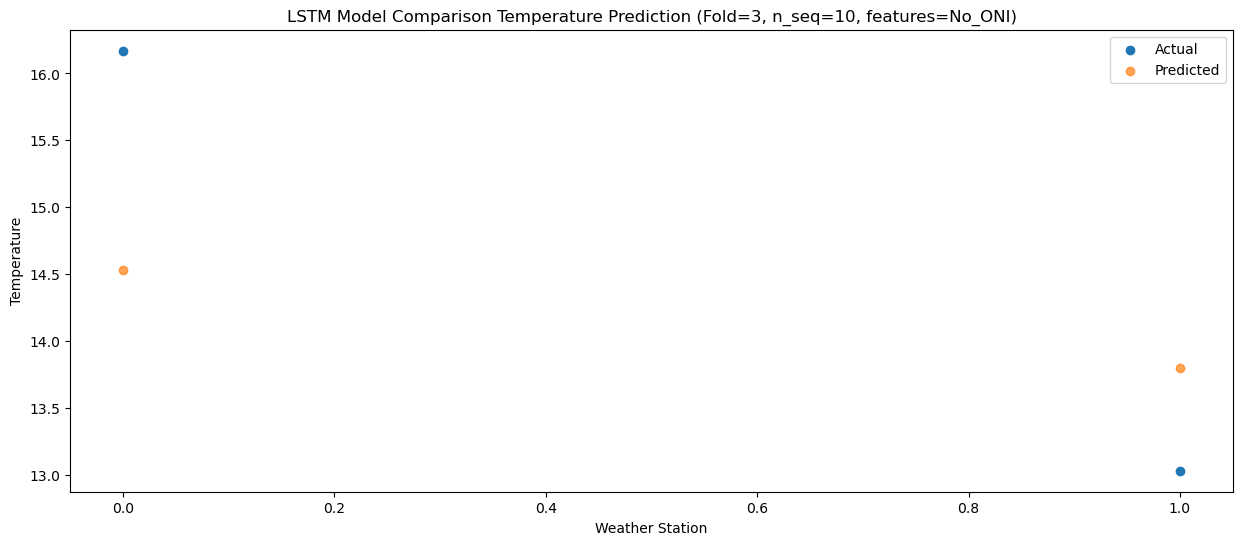

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.499019
1                1   14.13  14.767888


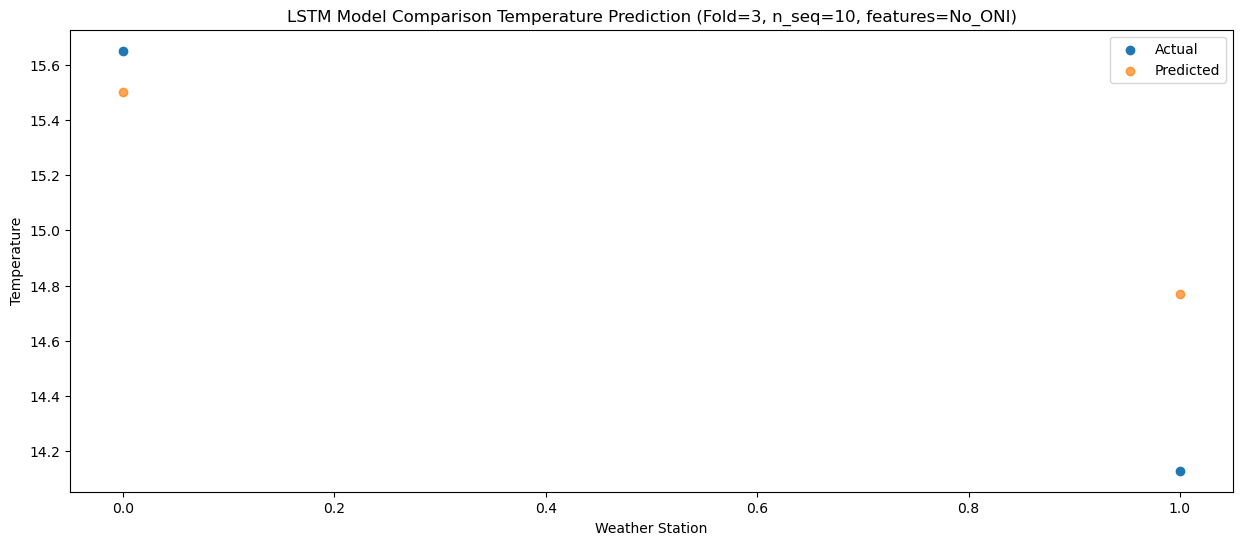

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.241709
1                1   15.42  15.510329


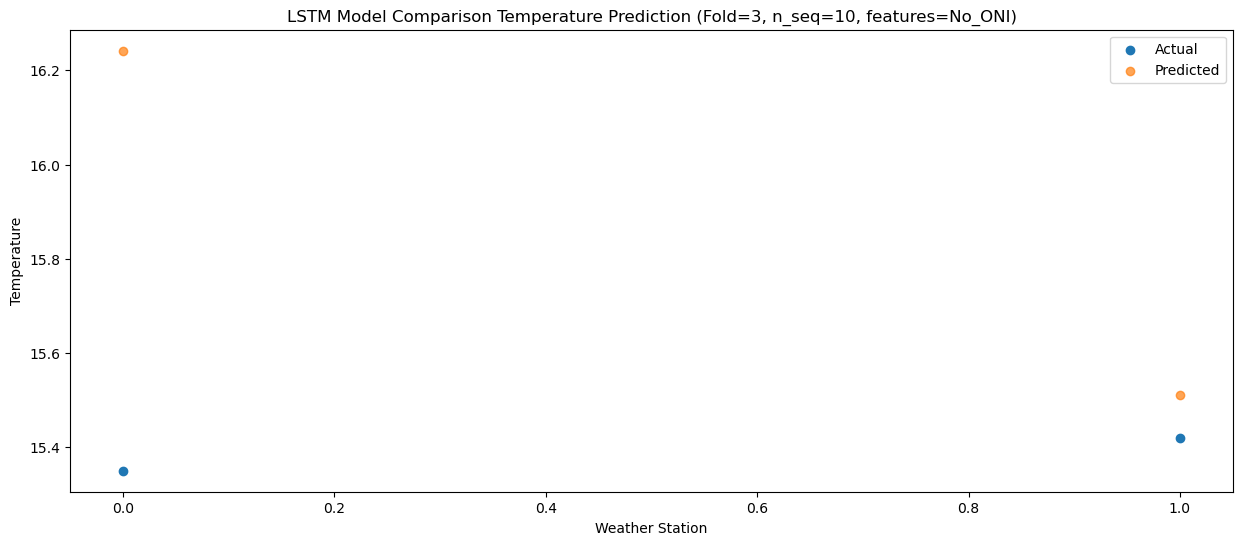

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.018448
1                1   15.25  15.287911


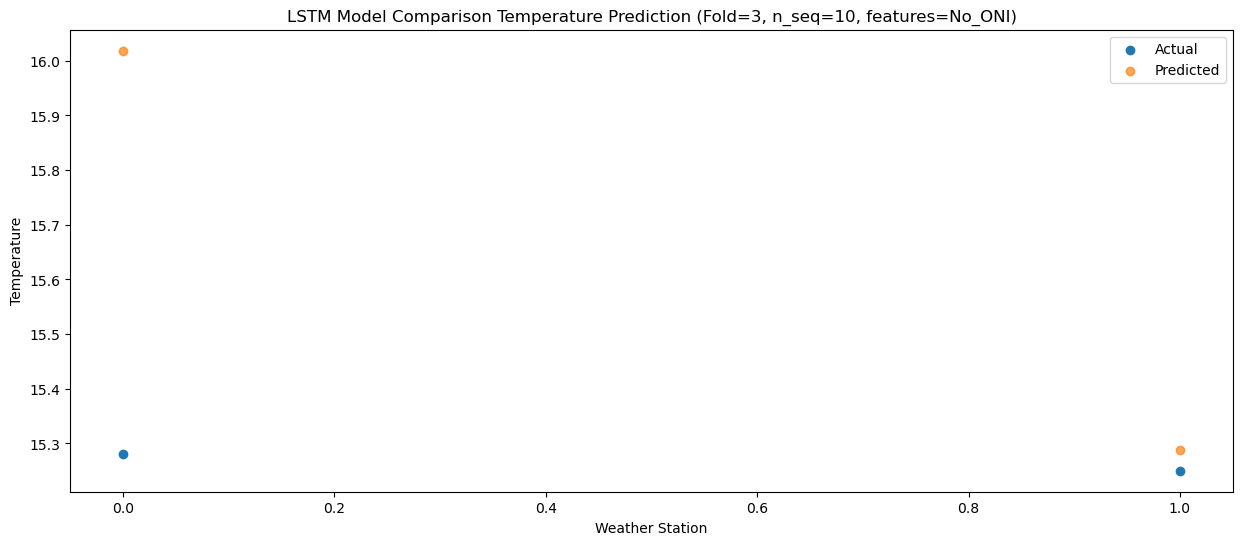

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  15.403846
1                1   14.76  14.674476


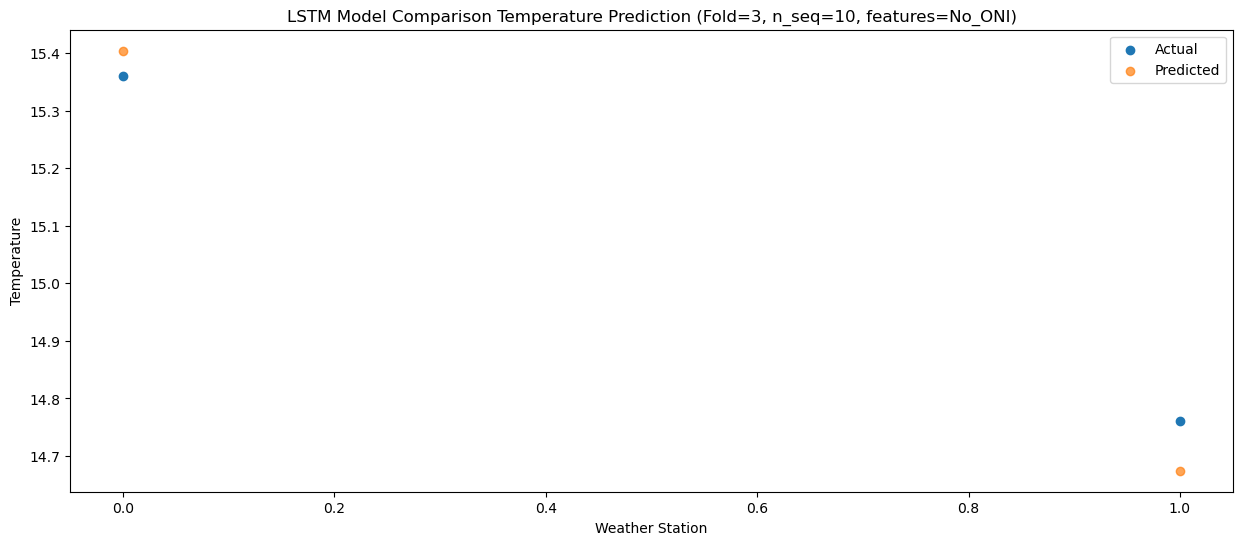

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.381943
1                1   15.17  14.653161


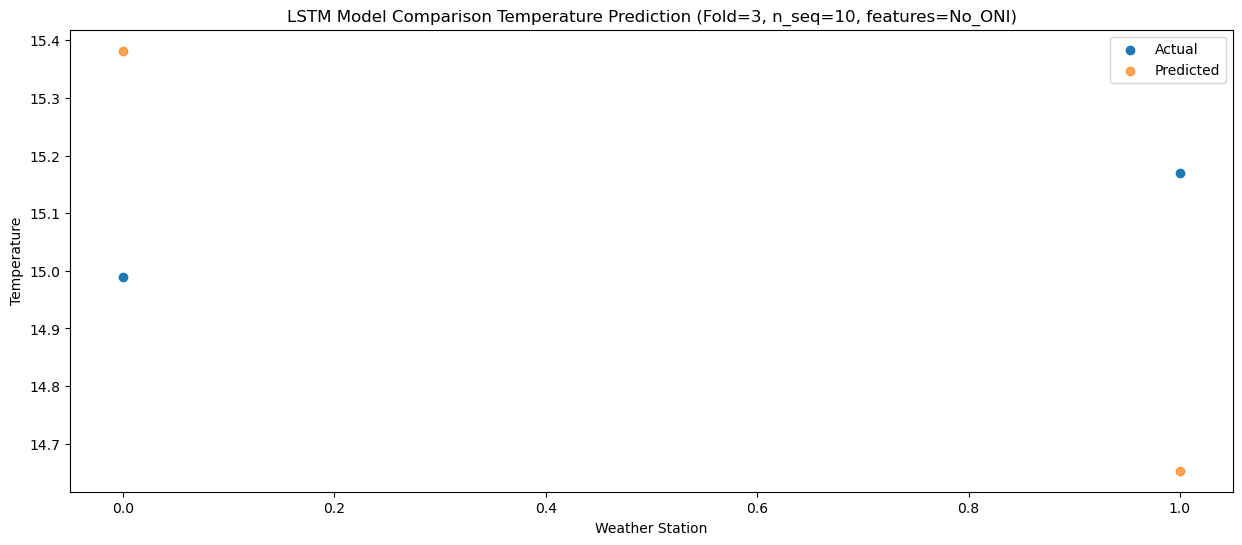

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  15.925581
1                1   15.05  15.195622


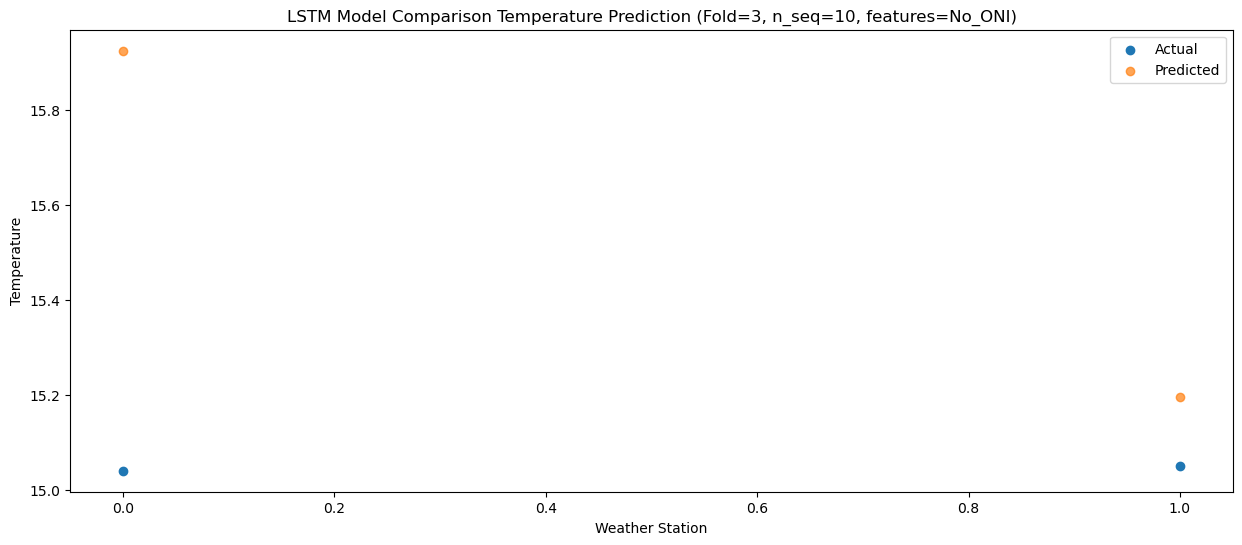

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  16.058459
1                1   14.85  15.328333


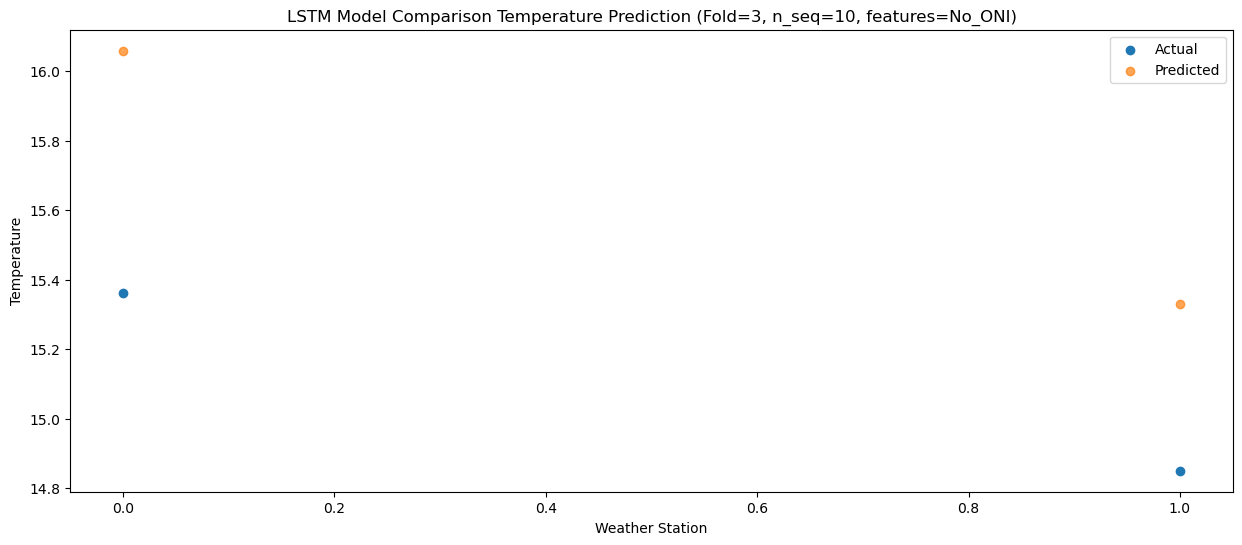

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  15.653278
1                1   14.55  14.923555


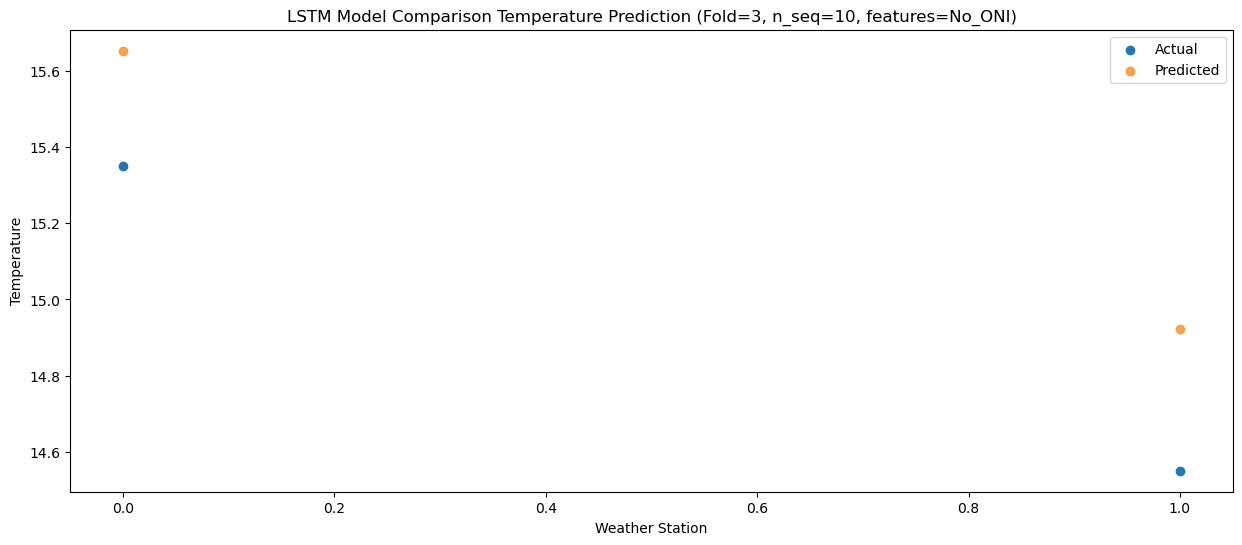

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  16.392595
1                1   15.57  15.661930


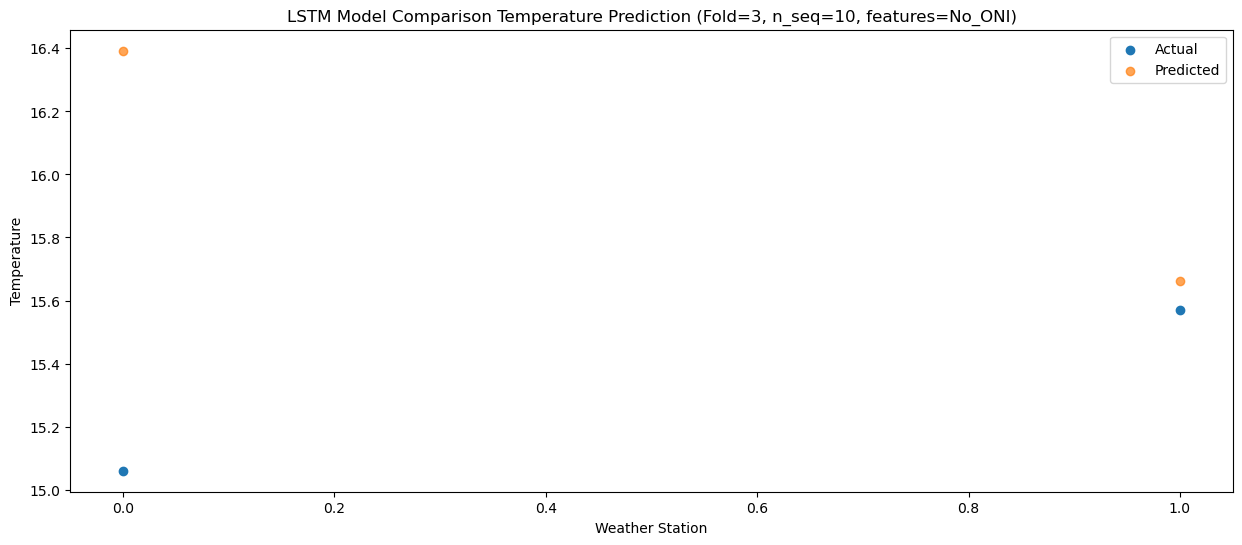

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.53014166 13.79982999]
 [15.49901904 14.76788786]
 [16.24170906 15.51032939]
 [16.01844835 15.28791132]
 [15.40384632 14.67447576]
 [15.38194317 14.65316113]
 [15.92558063 15.19562193]
 [16.05845869 15.32833299]
 [15.65327791 14.92355469]
 [16.39259491 15.66193018]]
Year at t+1:
t+1 SKRMSE: 1.280971
t+1 KRMSE: 1.280971
t+1 MAE: 1.204844
t+1 SKMAPE: 0.080247
t+1 R2_SCORE: 0.334299
t+1 KMAPE: 0.080247
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.463517
t+2 KRMSE: 0.463517
t+2 MAE: 0.394434
t+2 SKMAPE: 0.027396
t+2 R2_SCORE: 0.628033
t+2 KMAPE: 0.027396
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.633760
t+3 KRMSE: 0.633760
t+3 MAE: 0.491019
t+3 SKMAPE: 0.031975
t+3 R2_SCORE: -326.879367
t+3 KMAPE: 0.031975
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.522850
t+4 KRMSE: 0.522850
t+4 MAE: 0.388180
t+4 SKMAPE: 0.025407
t+

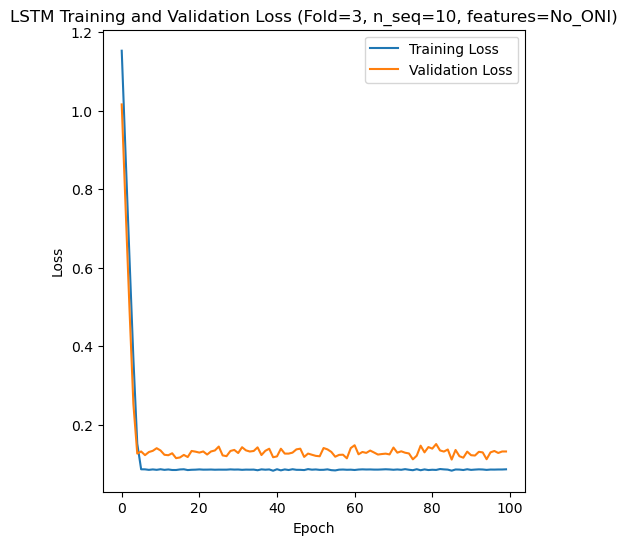

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 24s 364ms/step - loss: 0.9520 - accuracy: 0.0000e+00 - mae: 0.8532 - rmse: 0.9520 - mape: 132.8577 - pearson: 0.2395 - val_loss: 0.8336 - val_accuracy: 0.0000e+00 - val_mae: 0.7364 - val_rmse: 0.8336 - val_mape: 117.7100 - val_pearson: 0.1373
Epoch 2/100
19/19 [==============================] - 1s 77ms/step - loss: 0.7128 - accuracy: 0.0000e+00 - mae: 0.6346 - rmse: 0.7128 - mape: 98.3774 - pearson: 0.2273 - val_loss: 0.5992 - val_accuracy: 0.0000e+00 - val_mae: 0.5199 - val_rmse: 0.5992 - val_mape: 82.0324 - val_pearson: 0.1246
Epoch 3/100
19/19 [==============================] - 2s 83ms/step - loss:

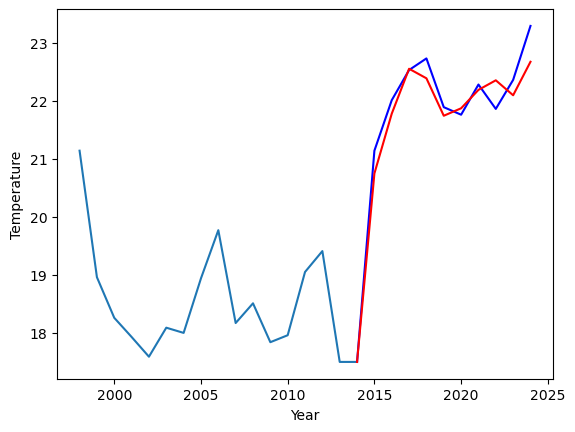

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.54		-0.09
14.58		13.57		-1.01
15.60		14.34		-1.26
15.53		14.18		-1.35
14.23		13.53		-0.70
13.53		13.66		0.13
14.09		13.98		-0.11
14.41		14.14		-0.27
13.54		13.89		0.35
15.02		14.46		-0.56


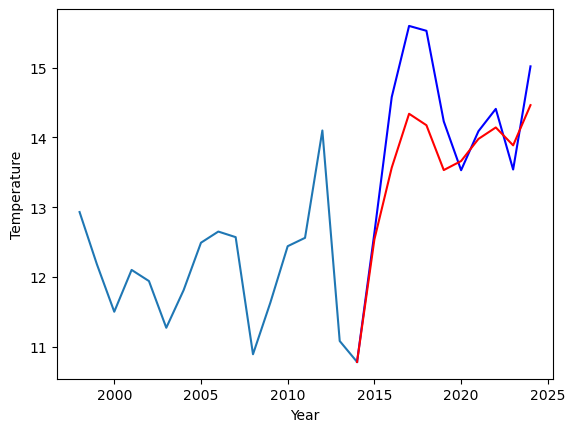

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.747244
1                1   12.63  12.537825


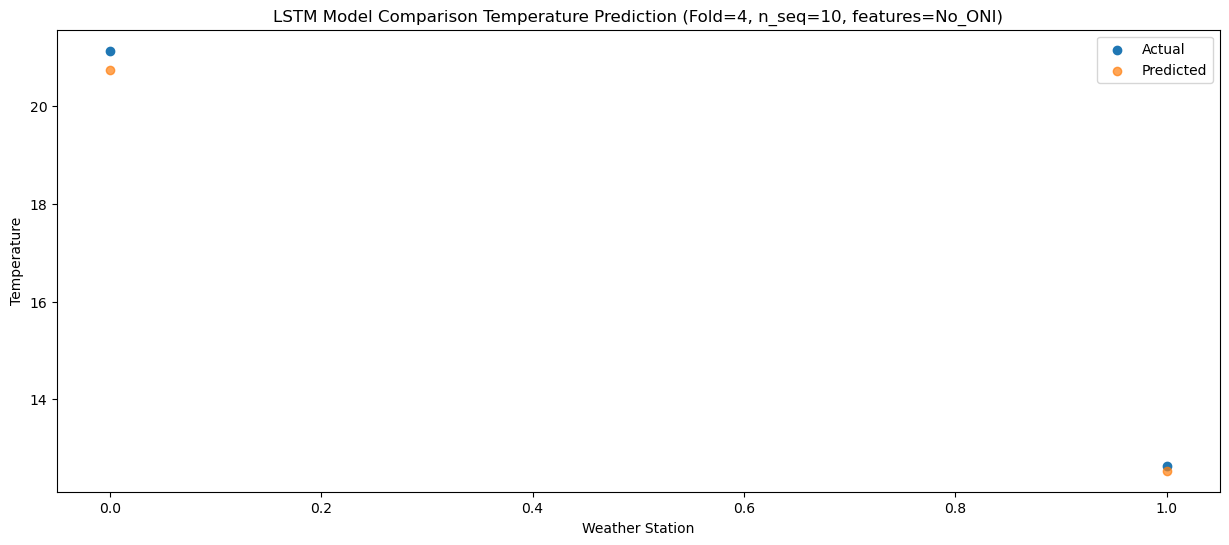

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.777366
1                1   14.58  13.567501


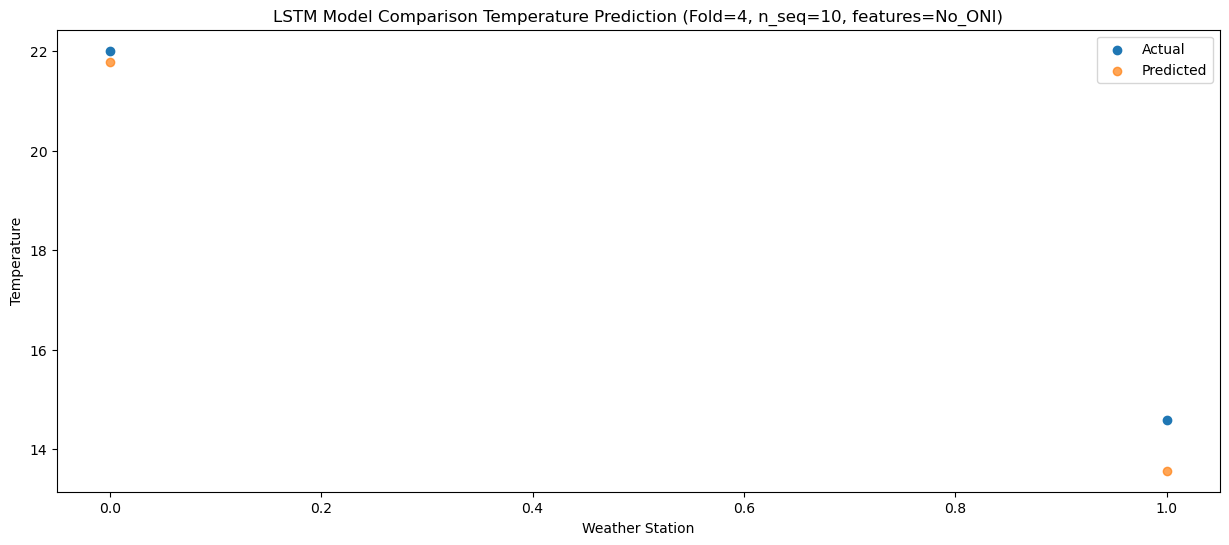

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.551878
1                1   15.60  14.340026


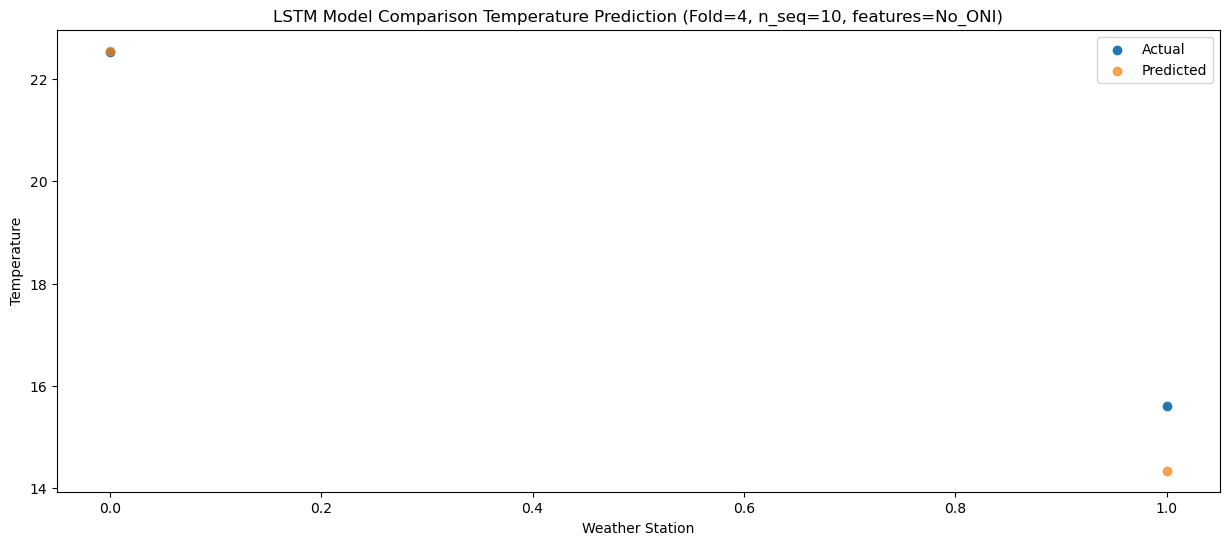

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73   22.38724
1                1   15.53   14.17558


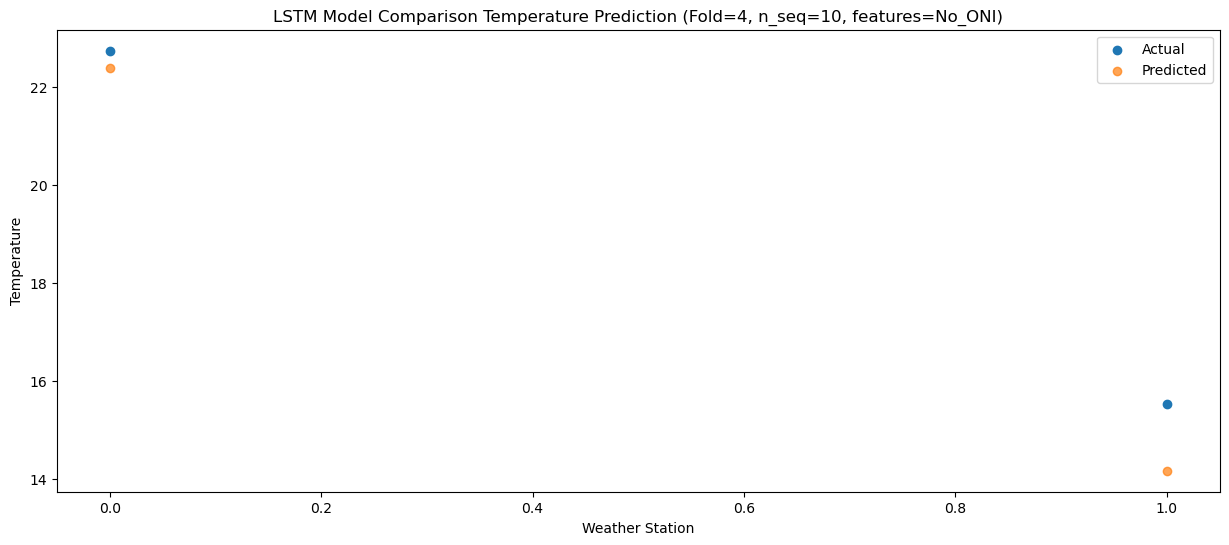

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.742150
1                1   14.23  13.532193


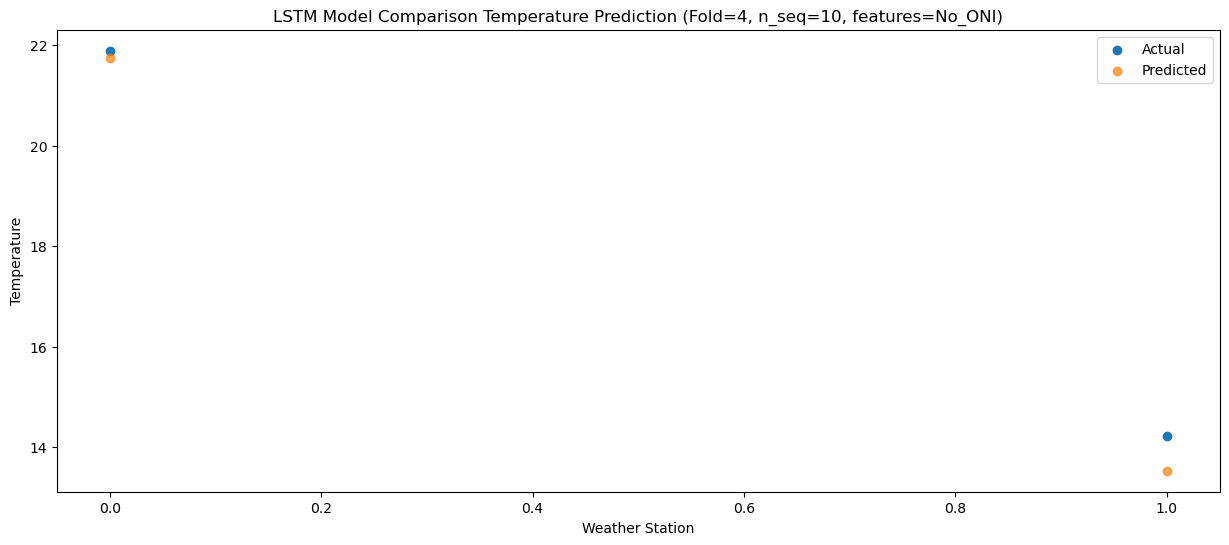

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.870658
1                1   13.53  13.661566


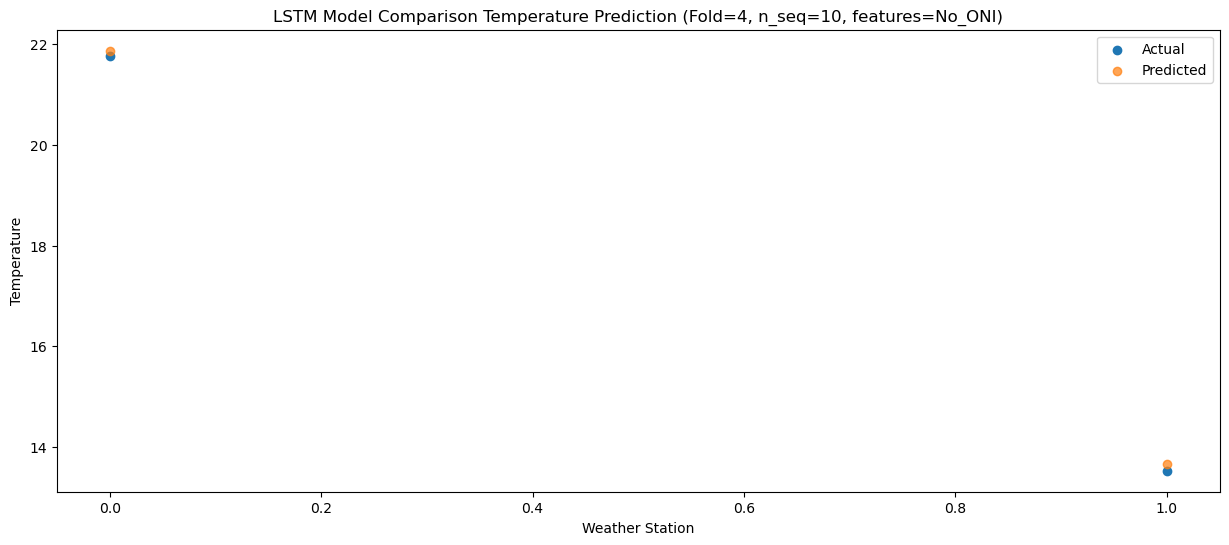

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.187771
1                1   14.09  13.978953


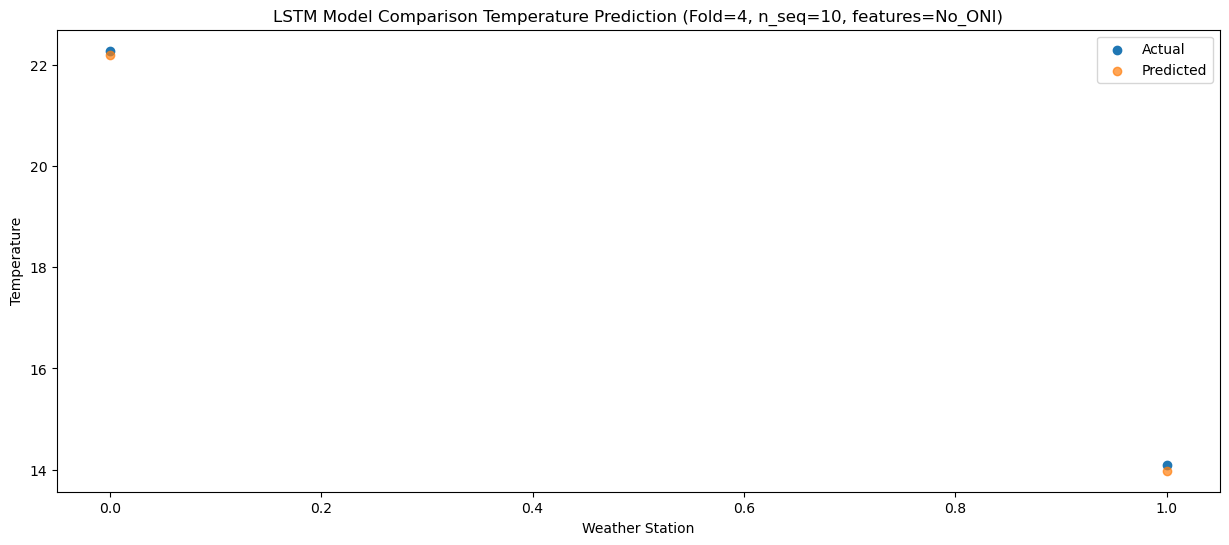

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.352861
1                1   14.41  14.143470


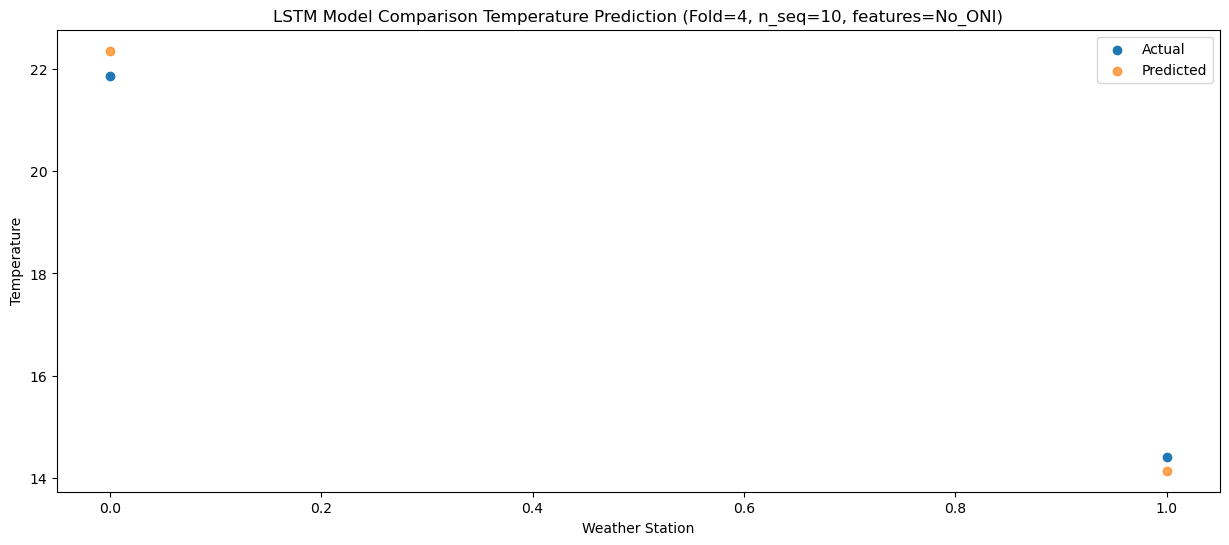

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  22.094894
1                1   13.54  13.886839


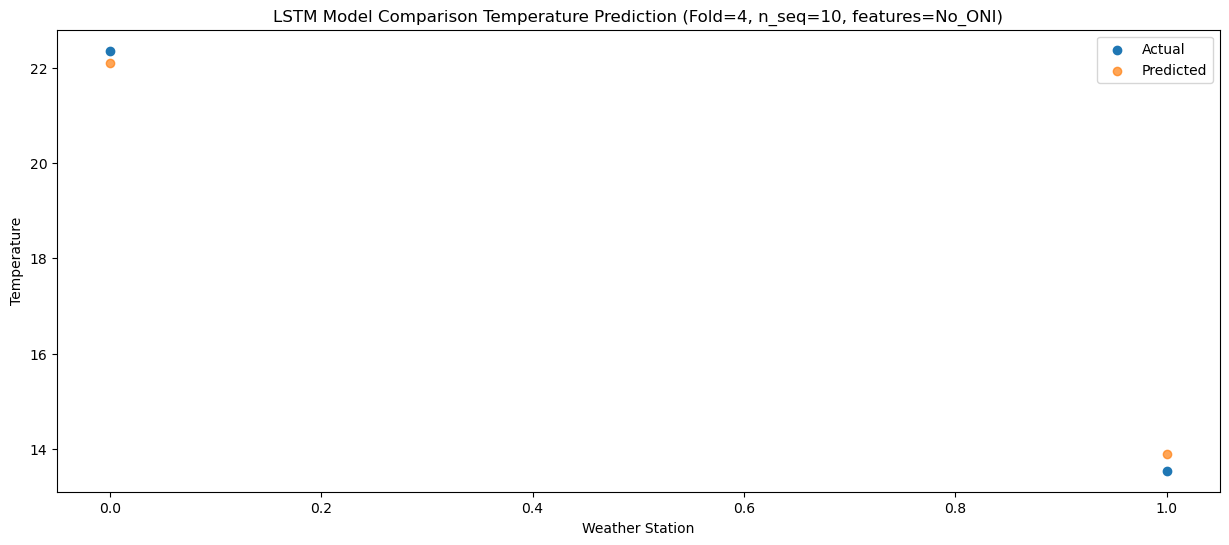

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.672115
1                1   15.02  14.463708


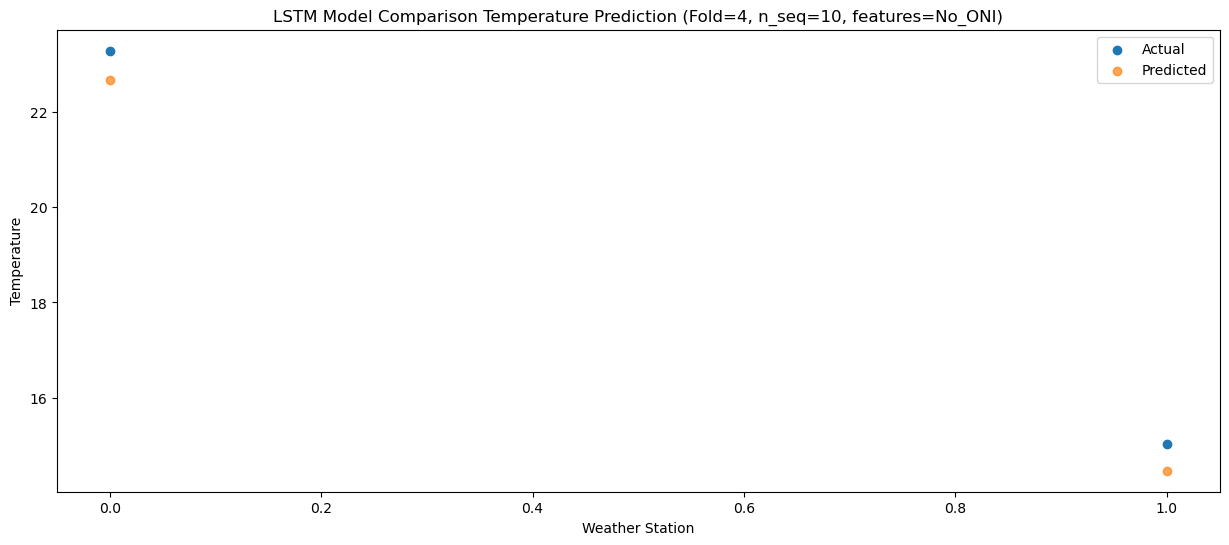

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.74724398 12.53782516]
 [21.77736579 13.56750052]
 [22.55187814 14.3400256 ]
 [22.38724005 14.17557969]
 [21.74214965 13.53219339]
 [21.87065831 13.66156561]
 [22.18777081 13.97895295]
 [22.35286123 14.14347018]
 [22.0948945  13.88683949]
 [22.67211482 14.46370778]]
Year at t+1:
t+1 SKRMSE: 0.285266
t+1 KRMSE: 0.285266
t+1 MAE: 0.242465
t+1 SKMAPE: 0.012938
t+1 R2_SCORE: 0.995505
t+1 KMAPE: 0.012938
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.734600
t+2 KRMSE: 0.734600
t+2 MAE: 0.622567
t+2 SKMAPE: 0.040007
t+2 R2_SCORE: 0.960899
t+2 KMAPE: 0.040007
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.891071
t+3 KRMSE: 0.891071
t+3 MAE: 0.640926
t+3 SKMAPE: 0.040869
t+3 R2_SCORE: 0.933867
t+3 KMAPE: 0.040869
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.987912
t+4 KRMSE: 0.987912
t+4 MAE: 0.848590
t+4 SKMAPE: 0.051146
t+4 R

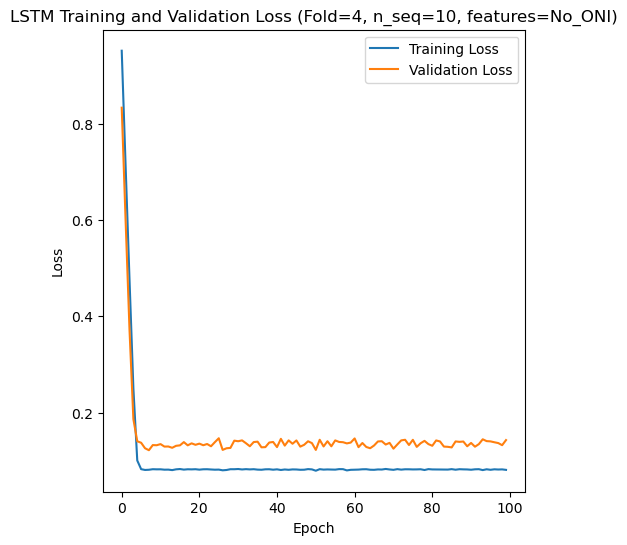

[[0.550976681111247], [0.5651762226051003], [0.44588985321214825], [0.6719145390884852], [0.5717052789388445]]
[[array(0.55097668)], [array(0.56517622)], [array(0.44588985)], [array(0.67191454)], [array(0.57170528)]]
[[0.37565560590475755], [0.4607780734151598], [0.31050424250215325], [0.5152229909338054], [0.42728839480876923]]
[[0.01947702582808332], [0.02295791044851904], [0.018155699527226284], [0.034248912183084616], [0.025731289861059707]]
[[0.9279371266441001], [-0.4193096944679078], [0.9471934522549672], [-0.15786629728291013], [0.9796100494632324]]
[[array(0.01947703)], [array(0.02295791)], [array(0.0181557)], [array(0.03424891)], [array(0.02573129)]]
[[array(0.95043443)], [array(0.3367116)], [array(0.97166131)], [array(0.27448999)], [array(0.98746772)]]
[[[20.526790466308594, 21.540541257858276, 22.298467543125152, 21.975681807994842, 21.479870166778564, 21.426155228316784, 21.930134851634502, 21.90069969572127, 21.400696000233292, 22.207279583588242], [16.256963379383087, 17

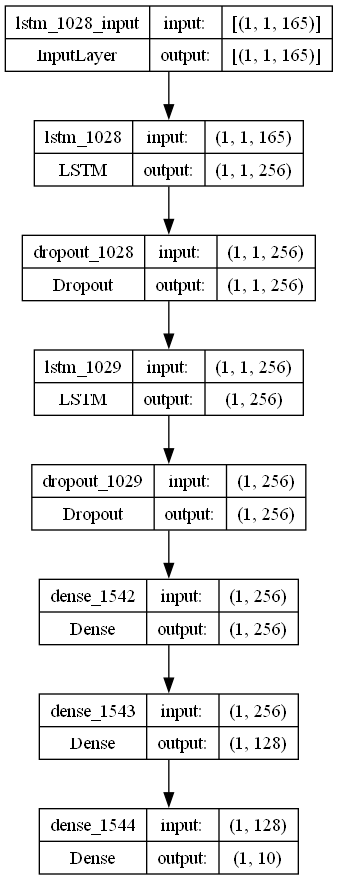

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.003123976759506953
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 256
    dropout_rate = 0.1492253500061234

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S10_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [53]:
print(series_ws)

1998    20.84
1999    20.69
2000    20.47
2001    20.30
2002    20.46
2003    20.31
2004    20.43
2005    20.63
2006    21.05
2007    20.79
2008    20.30
2009    20.47
2010    19.79
2011    21.11
2012    21.38
2013    20.92
2014    20.47
2015    21.77
2016    22.50
2017    22.86
2018    21.64
2019    21.57
2020    21.74
2021    21.57
2022    21.81
2023    22.23
2024    22.62
dtype: float64


In [54]:
print(series_ws[:n_lag+2+len(forecasts)].values)

[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
 19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
 21.81 22.23]
